# 1. Introdução e Objetivos

Objetivos do Notebook:

- Realizar uma análise exploratória robusta da base de dados de vendas.
- Corrigir anomalias, tratar outliers e transformar os dados conforme necessário.
- Gerar estatísticas descritivas (gerais e por tempo) e identificar padrões (por região, porte, etc.).
- Criar visualizações (gráficos de linha, barras, heatmaps, mapas choropleth e dashboards interativos) para embasar insights para a equipe de marketing.
- Documentar todas as decisões e justificativas adotadas na análise.
- Unir os dados de vendas com informações geográficas (dimensão dos municípios e latitude/longitude) para permitir análises espaciais.
- Aplicar métodos estatísticos robustos para gerar insights acionáveis para a equipe de marketing.
- Segmentar clientes e produtos para identificar oportunidades estratégicas.
- Analisar a elasticidade de preço e padrões de compra associados.
- Calcular o valor vitalício do cliente (LTV) para otimizar estratégias de retenção.

# 2. Importação das Bibliotecas 

Este notebook utiliza as seguintes bibliotecas:

- pandas e numpy: para manipulação e análise de dados.
- os: para manipulação de caminhos e diretórios.
- matplotlib.pyplot e seaborn: para criação de gráficos e visualizações.
- plotly.express: para gráficos interativos (mapas, treemaps, etc.).
- json: para manipulação de dados em formato JSON (por exemplo, para arquivos GeoJSON).
- scikit-learn (StandardScaler, KMeans, PCA): para escalonamento e clustering.
- scipy.stats: para testes estatísticos.
- statsmodels: para análise de séries temporais e decomposição.
- mlxtend: para análise de cesta de compras.
- networkx: para visualização de redes (associação de produtos).
- ipywidgets e IPython.display: para criar interatividade no notebook.

In [46]:
# Importar bibliotecas essenciais
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
import warnings

# Filtrar avisos para melhorar a legibilidade da saída
warnings.filterwarnings('ignore')

# Bibliotecas para análise estatística
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

# Bibliotecas para clustering e escalonamento
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Bibliotecas para análise de cestas de compras
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx

# Para interatividade no notebook
import ipywidgets as widgets
from IPython.display import display

# Configurar o estilo dos gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True

# Exibir a versão do pandas (opcional)
print("Versão do pandas:", pd.__version__)

Versão do pandas: 2.2.3


# 3. Configuração de Caminhos e Leitura dos Arquivos

Nesta seção, configuramos os caminhos para os arquivos de dados e os exibimos para conferência.
A planilha de latitudes/longitudes amplia nosso poder de análise geográfica e será unida aos dados de vendas.

In [47]:
# Definir o diretório base
base_dir = os.getcwd()  # ou use os.path.dirname(__file__) se estiver rodando como script

# Especificar os caminhos dos arquivos
vendas_path = os.path.join(base_dir, "fat_vendas.csv")
mun_path = os.path.join(base_dir, "dim_municipios.csv")
latlong_path = os.path.join(base_dir, "lat long.xlsx")

# Exibir os caminhos para conferência
print("Caminho de vendas:", vendas_path)
print("Caminho de municípios:", mun_path)
print("Caminho de lat/long:", latlong_path)

Caminho de vendas: c:\Users\gonca\OneDrive\009 PERSONAL\CV\Processos Seletivos\mauricio-goncalves-analista-dados-fiesc\5_analise_dados_vendas\fat_vendas.csv
Caminho de municípios: c:\Users\gonca\OneDrive\009 PERSONAL\CV\Processos Seletivos\mauricio-goncalves-analista-dados-fiesc\5_analise_dados_vendas\dim_municipios.csv
Caminho de lat/long: c:\Users\gonca\OneDrive\009 PERSONAL\CV\Processos Seletivos\mauricio-goncalves-analista-dados-fiesc\5_analise_dados_vendas\lat long.xlsx


# 4. Leitura e Inspeção Inicial dos Dados

Leitura dos três arquivos de dados (fat_vendas.csv, dim_municipios.csv e lat long.xlsx) e inspeção inicial das primeiras linhas e informações estruturais de cada DataFrame. Esta etapa é crucial para entender a estrutura dos dados antes de iniciar a análise e transformação.

In [48]:
# Ler os dados de vendas, municípios e lat/long
df_vendas = pd.read_csv(vendas_path, sep=",", encoding="utf-8")  # Ajuste sep ou encoding se necessário
df_mun = pd.read_csv(mun_path, sep=",", encoding="utf-8")         # Ajuste sep/encoding se necessário
df_latlong = pd.read_excel(latlong_path)

# Exibir as primeiras linhas dos DataFrames
print("=== fat_vendas (primeiras linhas) ===")
display(df_vendas.head())

print("\n=== dim_municipios (primeiras linhas) ===")
display(df_mun.head())

print("\n=== lat long (primeiras linhas) ===")
display(df_latlong.head())

# Exibir informações gerais para entender a estrutura
print("\nInfo de fat_vendas:")
df_vendas.info()

print("\nInfo de dim_municipios:")
df_mun.info()

print("\nInfo de lat long:")
df_latlong.info()

# Verificação inicial de valores nulos
print("\n=== Verificação inicial de valores nulos ===")
print("fat_vendas:")
print(df_vendas.isnull().sum())
print("\ndim_municipios:")
print(df_mun.isnull().sum())
print("\nlat long:")
print(df_latlong.isnull().sum())

=== fat_vendas (primeiras linhas) ===


,ID_cliente,data,produto,valor,porte,codigo_municipio
0,2068915da032c82550a2a33108ec39891ba5dfefdb4e73...,1412022,produto_14,50.00,Grande,4202404
1,2068915da032c82550a2a33108ec39891ba5dfefdb4e73...,1412022,produto_14,50.00,Grande,4202404
2,2068915da032c82550a2a33108ec39891ba5dfefdb4e73...,1412022,produto_14,50.00,Grande,4202404
3,2068915da032c82550a2a33108ec39891ba5dfefdb4e73...,1522023,produto_00,430.35,Grande,4202404
4,2068915da032c82550a2a33108ec39891ba5dfefdb4e73...,1522023,produto_00,430.35,Grande,4202404



=== dim_municipios (primeiras linhas) ===


,CD7_IBGE_MUN,NM_MUN,SG_UF,NM_MICRO,NM_MESO
0,3146305,Padre Paraíso,MG,Araçuaí,Jequitinhonha
1,3146404,Paineiras,MG,Três Marias,Central Mineira
2,3146503,Pains,MG,Formiga,Oeste de Minas
3,3146552,Pai Pedro,MG,Janaúba,Norte de Minas
4,3146602,Paiva,MG,Juiz de Fora,Zona da Mata



=== lat long (primeiras linhas) ===


,CD_IBGE,LONG,LAT,ALT
0,1100015,-61.999824,-11.935540,337.74
1,1100023,-63.033269,-9.908463,138.69
2,1100031,-60.544314,-13.499763,236.06
3,1100049,-61.442944,-11.433865,177.45
4,1100056,-60.818426,-13.195033,262.81



Info de fat_vendas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13711 entries, 0 to 13710
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID_cliente        13711 non-null  object 
 1   data              13711 non-null  int64  
 2   produto           13711 non-null  object 
 3   valor             13711 non-null  float64
 4   porte             13711 non-null  object 
 5   codigo_municipio  13711 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 642.8+ KB

Info de dim_municipios:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CD7_IBGE_MUN  5570 non-null   int64 
 1   NM_MUN        5570 non-null   object
 2   SG_UF         5570 non-null   object
 3   NM_MICRO      5570 non-null   object
 4   NM_MESO       5570 non-null   object
dtypes

# 5. Limpeza e Ajuste de Colunas

Nesta seção, realizamos a limpeza e padronização dos dados:
1. Definição de uma função para padronizar datas em diferentes formatos
2. Conversão da coluna "data" para o formato datetime
3. Verificação e tratamento de valores nulos
4. Validação da integridade entre as tabelas (verificação de códigos IBGE)
5. Tratamento de outliers iniciais

In [49]:
# 5.1 Definição da função para padronizar datas
def padronizar_data(data_str):
    """
    Converte diferentes formatos de data para o formato padrão dd/mm/yyyy.
    Trata casos como ddmmyyyy, dd-mm-yyyy, etc.
    
    Args:
        data_str: String contendo a data em algum formato
        
    Returns:
        String formatada como dd/mm/yyyy ou a original se não for possível converter
    """
    # Converter para string caso não seja
    data_str = str(data_str).strip()
    
    # Remove caracteres não numéricos
    apenas_numeros = ''.join(c for c in data_str if c.isdigit())
    
    # Se tiver 8 dígitos, assume formato DDMMYYYY
    if len(apenas_numeros) == 8:
        return f"{apenas_numeros[:2]}/{apenas_numeros[2:4]}/{apenas_numeros[4:]}"
    
    # Retorna a string original se não conseguir padronizar
    return data_str

# Exibir as primeiras linhas da coluna "data" para verificar o formato dos dados
print("Exemplo de dados brutos da coluna 'data':")
print(df_vendas['data'].head(20))

# Aplicar a função padronizar_data para criar uma coluna auxiliar 'data_padronizada'
df_vendas["data_padronizada"] = df_vendas["data"].apply(padronizar_data)

# Exibir os primeiros exemplos de datas padronizadas
print("\nExemplo de datas antes e após padronização:")
display(df_vendas[["data", "data_padronizada"]].head(10))

# Converter para datetime com o formato adequado
try:
    # Primeiro, tentamos o formato padrão dd/mm/yyyy
    df_vendas["data"] = pd.to_datetime(df_vendas["data_padronizada"], format="%d/%m/%Y", errors="coerce")
except:
    # Se falhar, tentamos detectar automaticamente o formato
    df_vendas["data"] = pd.to_datetime(df_vendas["data_padronizada"], errors="coerce")

# Excluir a coluna auxiliar 'data_padronizada'
df_vendas.drop(columns=["data_padronizada"], inplace=True)

# 5.2 Converter 'valor' para o tipo numérico
df_vendas["valor"] = pd.to_numeric(df_vendas["valor"], errors="coerce")

# 5.3 Verificação e tratamento de valores nulos
print("\n=== Verificação de valores nulos após conversões ===")
print(df_vendas.isnull().sum())

# Tratar valores nulos em 'data'
# Registros com data nula não podem ser usados para análise temporal
# Opção 1: Remover os registros
registros_antes = len(df_vendas)
df_vendas = df_vendas.dropna(subset=["data"])
registros_depois = len(df_vendas)
print(f"\nRegistros removidos por data nula: {registros_antes - registros_depois}")

# Tratar valores nulos em 'valor'
# Opção: Substituir pela mediana dos valores
valor_mediana = df_vendas["valor"].median()
df_vendas["valor"].fillna(valor_mediana, inplace=True)

# 5.4 Validação da integridade entre tabelas
codigos_validos = set(df_mun['CD7_IBGE_MUN'].unique())
codigos_vendas = set(df_vendas['codigo_municipio'].unique())

print(f"\nCódigos municipais nas vendas: {len(codigos_vendas)}")
print(f"Códigos municipais válidos: {len(codigos_validos)}")
print(f"Códigos não encontrados: {len(codigos_vendas - codigos_validos)}")

if len(codigos_vendas - codigos_validos) > 0:
    print("Exemplos de códigos municipais não encontrados:")
    print(list(codigos_vendas - codigos_validos)[:5])
    
    # Tratar códigos inválidos
    print("\nTratando códigos municipais não encontrados...")
    # Opção: marcar como -1 para fins de análise
    df_vendas.loc[~df_vendas['codigo_municipio'].isin(codigos_validos), 'codigo_municipio'] = -1

# Exibir um resumo final do DataFrame df_vendas após a limpeza
print("\nResumo final do DataFrame df_vendas após limpeza:")
display(df_vendas.head())
print(df_vendas.info())

Exemplo de dados brutos da coluna 'data':
0      1412022
1      1412022
2      1412022
3      1522023
4      1522023
5      1522023
6      1412019
7      1412019
8      2362022
9      2362022
10     2662023
11     2662023
12    13102021
13    13102021
14     2152022
15     2182023
16     2182023
17     2182023
18     2182023
19     2182023
Name: data, dtype: int64

Exemplo de datas antes e após padronização:


,data,data_padronizada
0,1412022,1412022
1,1412022,1412022
2,1412022,1412022
3,1522023,1522023
4,1522023,1522023
5,1522023,1522023
6,1412019,1412019
7,1412019,1412019
8,2362022,2362022
9,2362022,2362022



=== Verificação de valores nulos após conversões ===
ID_cliente              0
data                11897
produto                 0
valor                   0
porte                   0
codigo_municipio        0
dtype: int64

Registros removidos por data nula: 11897

Códigos municipais nas vendas: 91
Códigos municipais válidos: 5570
Códigos não encontrados: 0

Resumo final do DataFrame df_vendas após limpeza:


,ID_cliente,data,produto,valor,porte,codigo_municipio
12,d58259aa5f9f2cb5451073e5d05700c16487d1c1f568f2...,2021-10-13,produto_00,154.86,Pequena,4218707
13,d58259aa5f9f2cb5451073e5d05700c16487d1c1f568f2...,2021-10-13,produto_00,154.86,Pequena,4218707
22,62718324b3ea7cbefe20559b22fcf60d391516c5080d02...,2021-11-22,produto_00,319.58,Grande,4209102
23,62718324b3ea7cbefe20559b22fcf60d391516c5080d02...,2021-11-22,produto_00,319.58,Grande,4209102
64,2714115428e53177f2f04b0ec49ff772287bc09a3b9c74...,2020-12-16,produto_28,93533.75,Grande,4205407


<class 'pandas.core.frame.DataFrame'>
Index: 1814 entries, 12 to 13644
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID_cliente        1814 non-null   object        
 1   data              1814 non-null   datetime64[ns]
 2   produto           1814 non-null   object        
 3   valor             1814 non-null   float64       
 4   porte             1814 non-null   object        
 5   codigo_municipio  1814 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 99.2+ KB
None


# 6. Criação do DataFrame Mesclado (Merge)

Objetivo: Unir as informações de vendas com os dados dos municípios e as coordenadas (lat/long) para enriquecer a análise geográfica.
Realizamos dois merges sequenciais:
1. Primeiro merge: unir fat_vendas com dim_municipios
2. Segundo merge: unir o resultado com a planilha de lat/long

Ao final, temos um DataFrame completo com todas as informações necessárias para análise.

In [50]:
# Primeiro merge: unir fat_vendas com dim_municipios
df_merged1 = pd.merge(
    df_vendas,
    df_mun,
    left_on="codigo_municipio",
    right_on="CD7_IBGE_MUN",
    how="left"
)

# Segundo merge: unir o resultado com a planilha de lat/long
# Supondo que df_latlong possui a chave "CD_IBGE"
df_merged = pd.merge(
    df_merged1,
    df_latlong,
    left_on="codigo_municipio",
    right_on="CD_IBGE",
    how="left"
)

print("=== df_merged (dados mesclados) ===")
display(df_merged.head())

# 6.1 Verificação de valores nulos após os merges
print("\n=== Verificação de valores nulos após merges ===")
print(df_merged.isnull().sum())

# 6.2 Tratamento de valores nulos em colunas específicas após os merges
# Para valores geográficos nulos, vamos preencher com a média da UF
print("\nTratando valores nulos após os merges...")

# Colunas municipais (UF, nome, etc) - preservar nulos ou atribuir "Não identificado"
df_merged['NM_MUN'].fillna('Não identificado', inplace=True)
df_merged['SG_UF'].fillna('NA', inplace=True)
df_merged['NM_MICRO'].fillna('Não identificado', inplace=True)
df_merged['NM_MESO'].fillna('Não identificado', inplace=True)

# Coordenadas geográficas - preencher com a média por UF
for uf in df_merged['SG_UF'].unique():
    if uf != 'NA':
        # Latitude
        lat_mean = df_merged[df_merged['SG_UF'] == uf]['LAT'].mean()
        df_merged.loc[(df_merged['SG_UF'] == uf) & (df_merged['LAT'].isnull()), 'LAT'] = lat_mean
        
        # Longitude
        long_mean = df_merged[df_merged['SG_UF'] == uf]['LONG'].mean()
        df_merged.loc[(df_merged['SG_UF'] == uf) & (df_merged['LONG'].isnull()), 'LONG'] = long_mean

# Verificar valores nulos após o tratamento
print("\n=== Verificação de valores nulos após tratamento ===")
print(df_merged.isnull().sum())

=== df_merged (dados mesclados) ===


,ID_cliente,data,produto,valor,porte,codigo_municipio,CD7_IBGE_MUN,NM_MUN,SG_UF,NM_MICRO,NM_MESO,CD_IBGE,LONG,LAT,ALT
0,d58259aa5f9f2cb5451073e5d05700c16487d1c1f568f2...,2021-10-13,produto_00,154.86,Pequena,4218707,4218707,Tubarão,SC,Tubarão,Sul Catarinense,4218707,-49.005268,-28.480034,15.64
1,d58259aa5f9f2cb5451073e5d05700c16487d1c1f568f2...,2021-10-13,produto_00,154.86,Pequena,4218707,4218707,Tubarão,SC,Tubarão,Sul Catarinense,4218707,-49.005268,-28.480034,15.64
2,62718324b3ea7cbefe20559b22fcf60d391516c5080d02...,2021-11-22,produto_00,319.58,Grande,4209102,4209102,Joinville,SC,Joinville,Norte Catarinense,4209102,-48.849409,-26.304518,10.30
3,62718324b3ea7cbefe20559b22fcf60d391516c5080d02...,2021-11-22,produto_00,319.58,Grande,4209102,4209102,Joinville,SC,Joinville,Norte Catarinense,4209102,-48.849409,-26.304518,10.30
4,2714115428e53177f2f04b0ec49ff772287bc09a3b9c74...,2020-12-16,produto_28,93533.75,Grande,4205407,4205407,Florianópolis,SC,Florianópolis,Grande Florianópolis,4205407,-48.547637,-27.587796,21.97



=== Verificação de valores nulos após merges ===
ID_cliente          0
data                0
produto             0
valor               0
porte               0
codigo_municipio    0
CD7_IBGE_MUN        0
NM_MUN              0
SG_UF               0
NM_MICRO            0
NM_MESO             0
CD_IBGE             0
LONG                0
LAT                 0
ALT                 0
dtype: int64

Tratando valores nulos após os merges...

=== Verificação de valores nulos após tratamento ===
ID_cliente          0
data                0
produto             0
valor               0
porte               0
codigo_municipio    0
CD7_IBGE_MUN        0
NM_MUN              0
SG_UF               0
NM_MICRO            0
NM_MESO             0
CD_IBGE             0
LONG                0
LAT                 0
ALT                 0
dtype: int64


# 7. Análise Exploratória dos Dados

Nesta seção, realizamos uma análise exploratória inicial para entender a distribuição e características dos dados:
1. Estatísticas básicas da coluna "valor"
2. Distribuição de vendas por UF
3. Distribuição temporal das vendas
4. Análise exploratória do comportamento dos clientes

Resumo estatístico de 'valor':


count      1814.000000
mean       2306.914410
std       18824.798219
min           3.140000
25%          50.620000
50%         116.840000
75%         267.847500
max      280884.240000
Name: valor, dtype: float64

Valor total de vendas por UF:


,SG_UF,valor
8,SC,3696042.24
7,RS,399985.00
6,PR,36170.95
5,MS,24934.00
9,SP,18274.15
2,CE,7632.00
1,BA,896.00
0,AM,385.00
4,GO,263.40
3,DF,160.00


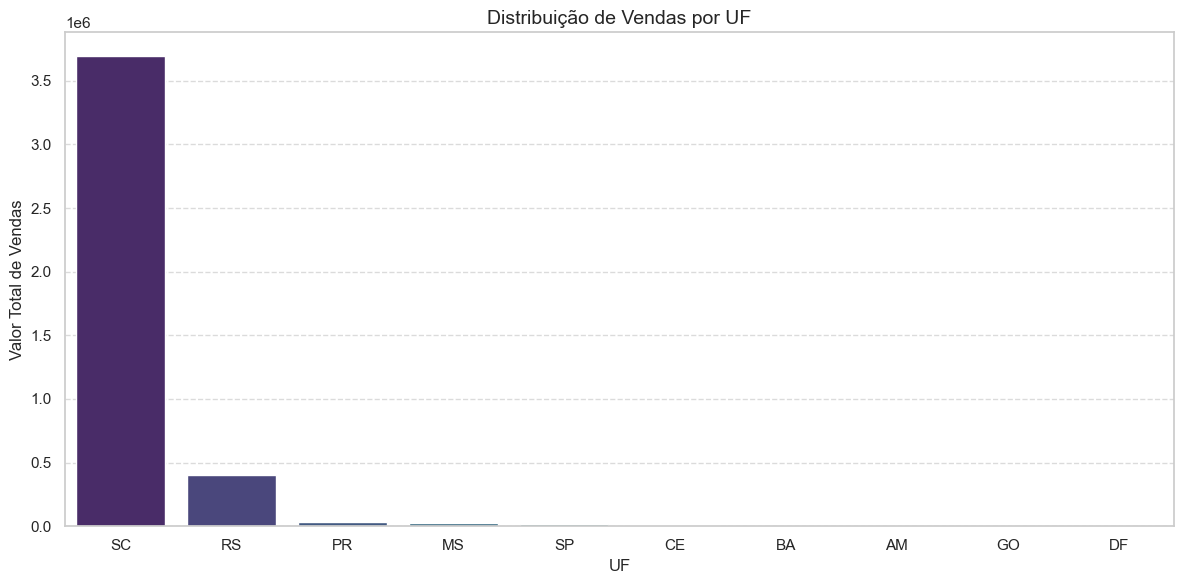

Estatísticas de vendas por porte de empresa:


,porte,valor_total,num_vendas,ticket_medio
0,Grande,4098072.98,1414,2898.212857
1,Media,68888.04,256,269.093906
2,Pequena,17781.72,144,123.484167


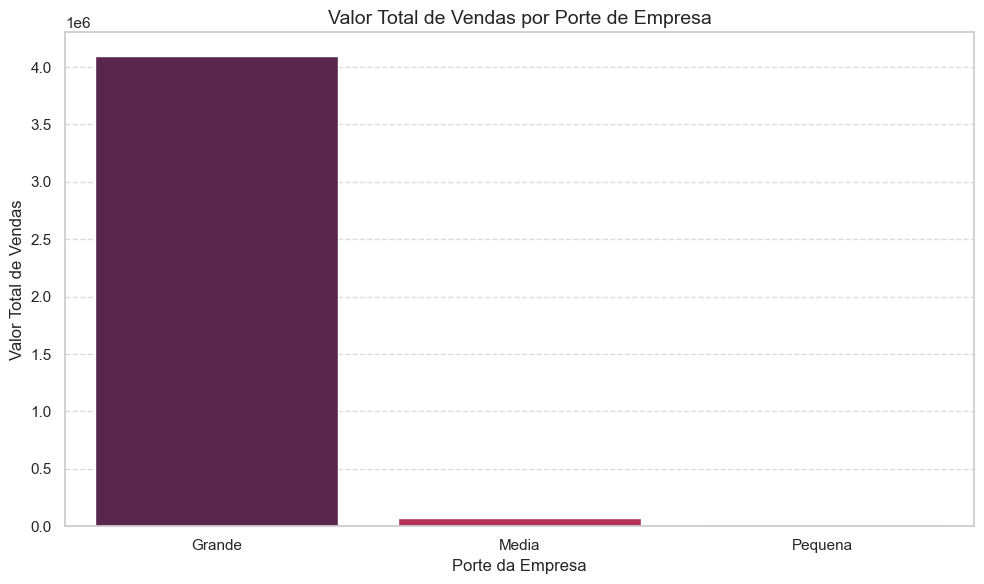

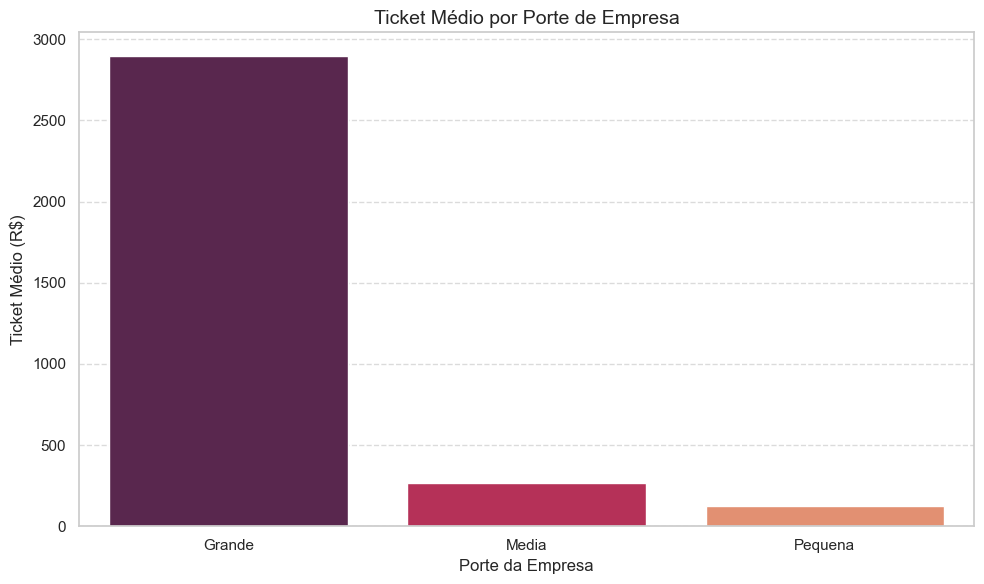

Estatísticas de vendas por ano:


,ano,valor_total,num_vendas,ticket_medio
0,2019,688502.74,541,1272.648318
1,2020,474914.68,483,983.260207
2,2021,2589322.41,402,6441.100522
3,2022,432002.91,388,1113.409562


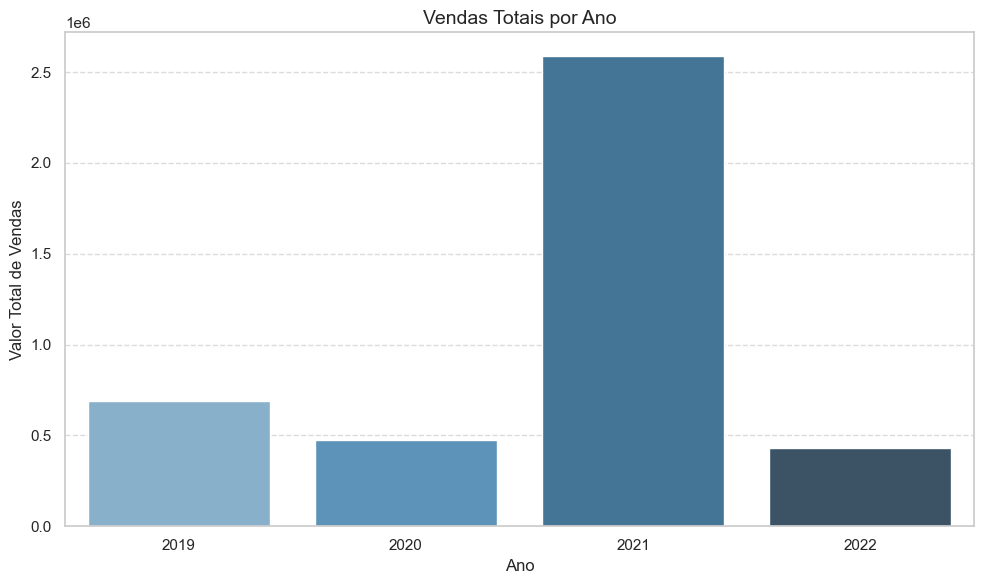

In [51]:
# 7.1 Estatísticas básicas de "valor"
print("Resumo estatístico de 'valor':")
display(df_merged["valor"].describe())

# 7.2 Verificar a distribuição de vendas por UF
if "SG_UF" in df_merged.columns:
    vendas_por_uf = df_merged.groupby("SG_UF")["valor"].sum().reset_index()
    vendas_por_uf = vendas_por_uf.sort_values("valor", ascending=False)
    
    print("Valor total de vendas por UF:")
    display(vendas_por_uf)
    
    # Visualizando a distribuição de vendas por UF
    plt.figure(figsize=(12, 6))
    sns.barplot(data=vendas_por_uf, x="SG_UF", y="valor", palette="viridis")
    plt.title("Distribuição de Vendas por UF", fontsize=14)
    plt.xlabel("UF")
    plt.ylabel("Valor Total de Vendas")
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 7.3 Verificar a distribuição de vendas por porte de empresa
if "porte" in df_merged.columns:
    vendas_por_porte = df_merged.groupby("porte")["valor"].agg(['sum', 'count', 'mean']).reset_index()
    vendas_por_porte.columns = ['porte', 'valor_total', 'num_vendas', 'ticket_medio']
    vendas_por_porte = vendas_por_porte.sort_values("valor_total", ascending=False)
    
    print("Estatísticas de vendas por porte de empresa:")
    display(vendas_por_porte)
    
    # Visualizando a distribuição de vendas por porte
    plt.figure(figsize=(10, 6))
    sns.barplot(data=vendas_por_porte, x="porte", y="valor_total", palette="rocket")
    plt.title("Valor Total de Vendas por Porte de Empresa", fontsize=14)
    plt.xlabel("Porte da Empresa")
    plt.ylabel("Valor Total de Vendas")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Ticket médio por porte
    plt.figure(figsize=(10, 6))
    sns.barplot(data=vendas_por_porte, x="porte", y="ticket_medio", palette="rocket")
    plt.title("Ticket Médio por Porte de Empresa", fontsize=14)
    plt.xlabel("Porte da Empresa")
    plt.ylabel("Ticket Médio (R$)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 7.4 Análise Exploratória Temporal - Tendência geral
# Criar colunas temporais auxiliares
df_merged['ano'] = df_merged['data'].dt.year
df_merged['mes'] = df_merged['data'].dt.month
df_merged['dia'] = df_merged['data'].dt.day
df_merged['dia_semana'] = df_merged['data'].dt.dayofweek
df_merged['trimestre'] = df_merged['data'].dt.quarter

# Vendas por ano
vendas_por_ano = df_merged.groupby('ano')['valor'].agg(['sum', 'count', 'mean']).reset_index()
vendas_por_ano.columns = ['ano', 'valor_total', 'num_vendas', 'ticket_medio']

print("Estatísticas de vendas por ano:")
display(vendas_por_ano)

# Visualizar vendas por ano
plt.figure(figsize=(10, 6))
sns.barplot(data=vendas_por_ano, x='ano', y='valor_total', palette='Blues_d')
plt.title('Vendas Totais por Ano', fontsize=14)
plt.xlabel('Ano')
plt.ylabel('Valor Total de Vendas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 8. Tratamento e Análise de Outliers

Objetivo: Identificar registros com valores extremos (outliers) na coluna "valor" utilizando o método IQR e exibir alguns registros para análise.

1. Calculamos os quartis Q1 e Q3 para determinar o intervalo interquartil (IQR)
2. Definimos limites para identificar outliers (1.5 * IQR abaixo de Q1 ou acima de Q3)
3. Identificamos e analisamos os registros considerados outliers
4. Decidimos se devemos tratar, remover ou manter os outliers com base em sua natureza

O tratamento adequado de outliers é essencial para evitar distorções nas análises estatísticas.

Análise de outliers pelo método IQR:
Q1 (25%): 50.62
Q3 (75%): 267.85
IQR: 217.23
Limite inferior: -275.22
Limite superior: 593.69
Número de outliers identificados: 267 (14.72% dos dados)


,ID_cliente,data,produto,valor,porte,codigo_municipio,CD7_IBGE_MUN,NM_MUN,SG_UF,NM_MICRO,NM_MESO,CD_IBGE,LONG,LAT,ALT,ano,mes,dia,dia_semana,trimestre
4,2714115428e53177f2f04b0ec49ff772287bc09a3b9c74...,2020-12-16,produto_28,93533.75,Grande,4205407,4205407,Florianópolis,SC,Florianópolis,Grande Florianópolis,4205407,-48.547637,-27.587796,21.97,2020,12,16,2,4
36,78a068c820c7892b1d3efdd87e021f47730c565342c868...,2022-10-30,produto_63,953.13,Grande,4205407,4205407,Florianópolis,SC,Florianópolis,Grande Florianópolis,4205407,-48.547637,-27.587796,21.97,2022,10,30,6,4
37,78a068c820c7892b1d3efdd87e021f47730c565342c868...,2022-10-30,produto_63,953.13,Grande,4205407,4205407,Florianópolis,SC,Florianópolis,Grande Florianópolis,4205407,-48.547637,-27.587796,21.97,2022,10,30,6,4
38,78a068c820c7892b1d3efdd87e021f47730c565342c868...,2022-10-30,produto_63,953.13,Grande,4205407,4205407,Florianópolis,SC,Florianópolis,Grande Florianópolis,4205407,-48.547637,-27.587796,21.97,2022,10,30,6,4
39,78a068c820c7892b1d3efdd87e021f47730c565342c868...,2022-10-30,produto_63,953.13,Grande,4205407,4205407,Florianópolis,SC,Florianópolis,Grande Florianópolis,4205407,-48.547637,-27.587796,21.97,2022,10,30,6,4
128,28082f80a3112823b9fea039100ee1aa0743f024449290...,2022-11-28,produto_00,742.17,Grande,4209102,4209102,Joinville,SC,Joinville,Norte Catarinense,4209102,-48.849409,-26.304518,10.30,2022,11,28,0,4
202,561b31f17dd826ef502fe9d60fddec00e830c5c914008b...,2019-12-18,produto_00,740.07,Grande,4204608,4204608,Criciúma,SC,Criciúma,Sul Catarinense,4204608,-49.365940,-28.673572,52.10,2019,12,18,2,4
249,835269f05bf7104cf96034a3ec3e2c14656306ac7144f0...,2020-10-14,produto_01,3078.57,Grande,4212239,4212239,Paraíso,SC,São Miguel do Oeste,Oeste Catarinense,4212239,-53.675314,-26.615263,503.30,2020,10,14,2,4
255,38aa72ccd379e7e1e29b5ee9f8c4c8252e7f98c0d48e38...,2020-12-16,produto_00,6791.29,Grande,4205407,4205407,Florianópolis,SC,Florianópolis,Grande Florianópolis,4205407,-48.547637,-27.587796,21.97,2020,12,16,2,4
256,38aa72ccd379e7e1e29b5ee9f8c4c8252e7f98c0d48e38...,2020-12-16,produto_00,6791.29,Grande,4205407,4205407,Florianópolis,SC,Florianópolis,Grande Florianópolis,4205407,-48.547637,-27.587796,21.97,2020,12,16,2,4



Distribuição de outliers por UF:


,SG_UF,count
4,SC,214
3,RS,19
5,SP,13
2,PR,10
1,MS,7
0,CE,4



Produtos com mais outliers:


,produto,count
0,produto_00,87
4,produto_04,28
9,produto_12,22
12,produto_17,14
8,produto_11,14
16,produto_35,14
3,produto_03,13
1,produto_01,13
19,produto_42,11
7,produto_10,8


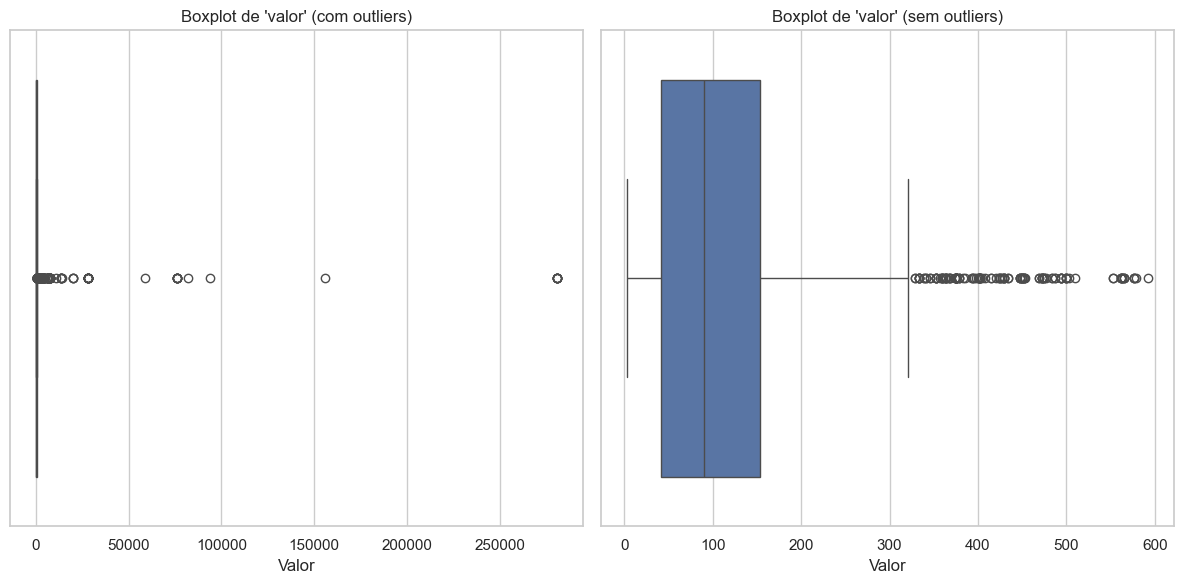


DataFrame original: 1814 registros
DataFrame sem outliers: 1547 registros
Diferença: 267 registros (14.72%)


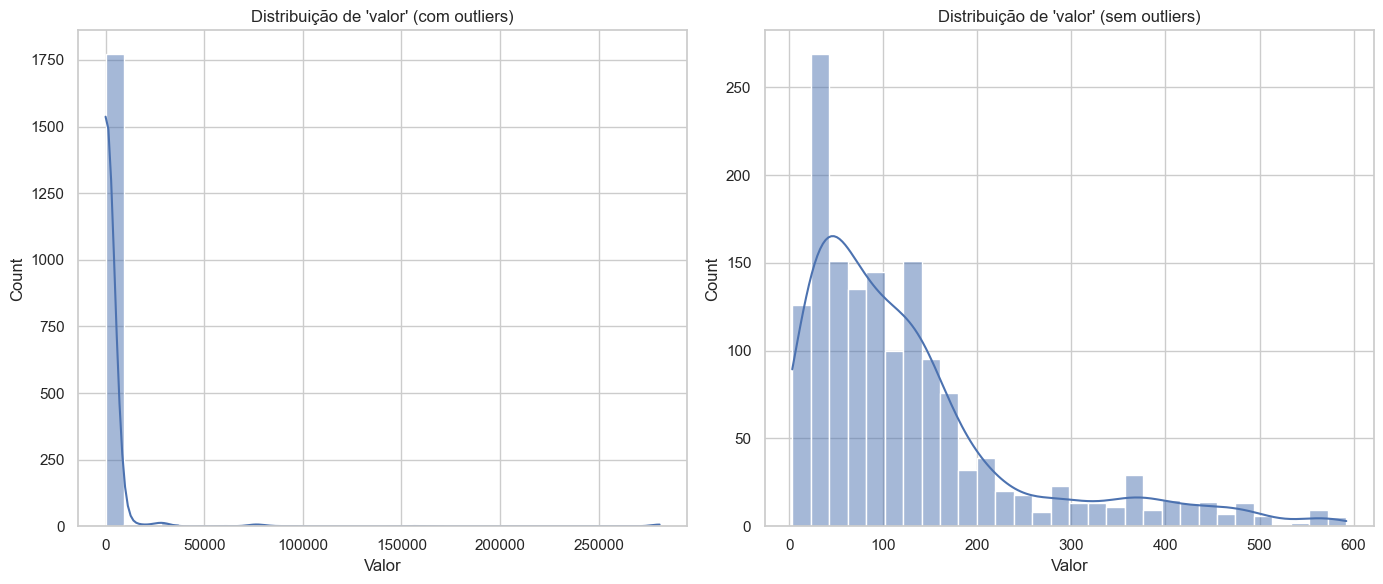

In [52]:
# 8.1 Identificação de outliers pelo método IQR
# Calcular Q1, Q3 e IQR
Q1 = df_merged["valor"].quantile(0.25)
Q3 = df_merged["valor"].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print("Análise de outliers pelo método IQR:")
print(f"Q1 (25%): {Q1:.2f}")
print(f"Q3 (75%): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Limite inferior: {limite_inferior:.2f}")
print(f"Limite superior: {limite_superior:.2f}")

# Identificar os outliers
outliers = df_merged[(df_merged["valor"] < limite_inferior) | (df_merged["valor"] > limite_superior)]
print(f"Número de outliers identificados: {len(outliers)} ({len(outliers)/len(df_merged)*100:.2f}% dos dados)")
display(outliers.head(10))

# 8.2 Análise detalhada dos outliers
# Outliers por UF
if "SG_UF" in df_merged.columns:
    outliers_por_uf = outliers.groupby("SG_UF").size().reset_index(name="count")
    outliers_por_uf = outliers_por_uf.sort_values("count", ascending=False)
    
    print("\nDistribuição de outliers por UF:")
    display(outliers_por_uf.head(10))

# Outliers por produto
if "produto" in df_merged.columns:
    outliers_por_produto = outliers.groupby("produto").size().reset_index(name="count")
    outliers_por_produto = outliers_por_produto.sort_values("count", ascending=False)
    
    print("\nProdutos com mais outliers:")
    display(outliers_por_produto.head(10))

# 8.3 Visualização dos outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=df_merged["valor"])
plt.title("Boxplot de 'valor' (com outliers)")
plt.xlabel("Valor")

plt.subplot(1, 2, 2)
# Boxplot sem outliers (para melhor visualização)
valores_sem_outliers = df_merged[(df_merged["valor"] >= limite_inferior) & (df_merged["valor"] <= limite_superior)]["valor"]
sns.boxplot(x=valores_sem_outliers)
plt.title("Boxplot de 'valor' (sem outliers)")
plt.xlabel("Valor")

plt.tight_layout()
plt.show()

# 8.4 Criar um DataFrame sem outliers para análises sensíveis
# Nota: Manteremos o DataFrame original para a maioria das análises,
# mas usaremos o filtrado para análises sensíveis a outliers
df_sem_outliers = df_merged[(df_merged["valor"] >= limite_inferior) & (df_merged["valor"] <= limite_superior)].copy()

print(f"\nDataFrame original: {len(df_merged)} registros")
print(f"DataFrame sem outliers: {len(df_sem_outliers)} registros")
print(f"Diferença: {len(df_merged) - len(df_sem_outliers)} registros ({(len(df_merged) - len(df_sem_outliers))/len(df_merged)*100:.2f}%)")

# 8.5 Distribuição de valores após tratamento
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_merged["valor"], kde=True, bins=30)
plt.title("Distribuição de 'valor' (com outliers)")
plt.xlabel("Valor")

plt.subplot(1, 2, 2)
sns.histplot(df_sem_outliers["valor"], kde=True, bins=30)
plt.title("Distribuição de 'valor' (sem outliers)")
plt.xlabel("Valor")

plt.tight_layout()
plt.show()

# 9. Análise de Sazonalidade e Tendências Temporais

Objetivo: Verificar padrões sazonais e tendências temporais nas vendas.

Realizamos as seguintes análises:
1. Evolução mensal das vendas com média móvel para suavização
2. Comparação mensal de vendas entre diferentes anos
3. Análise de decomposição da série temporal (tendência, sazonalidade, resíduos)
4. Identificação de padrões sazonais por dia da semana, mês e trimestre

Essas análises ajudam a equipe de marketing a planejar campanhas e ações alinhadas aos ciclos naturais de demanda.

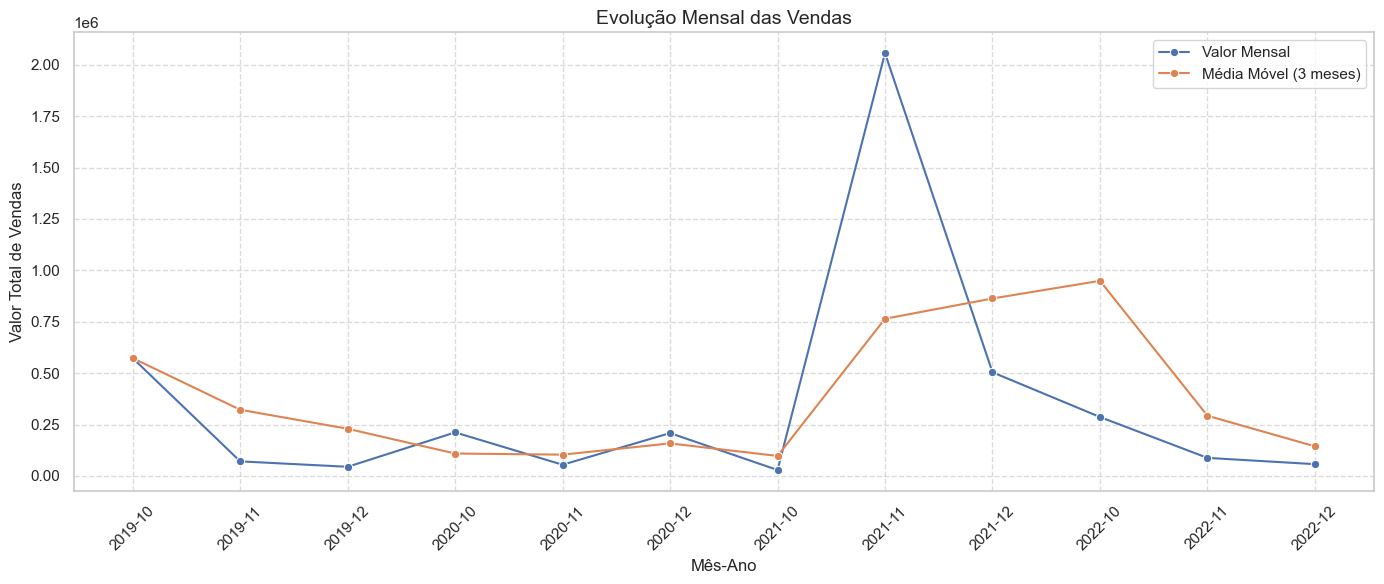

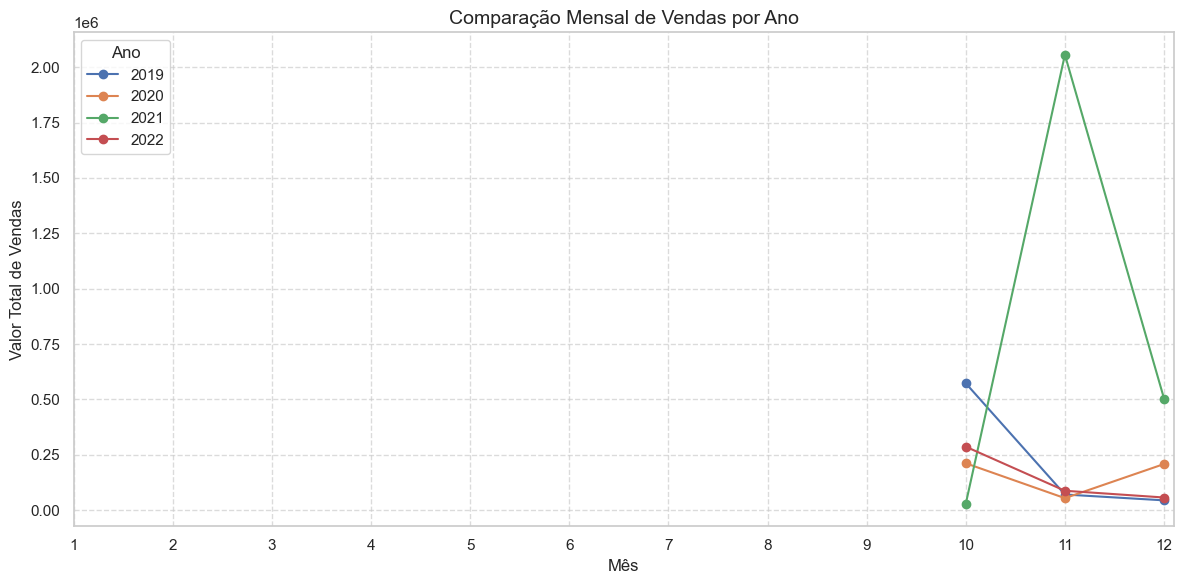

Não foi possível realizar a decomposição sazonal: Multiplicative seasonality is not appropriate for zero and negative values
Isso pode ocorrer devido à falta de dados suficientes ou irregularidades na série temporal.


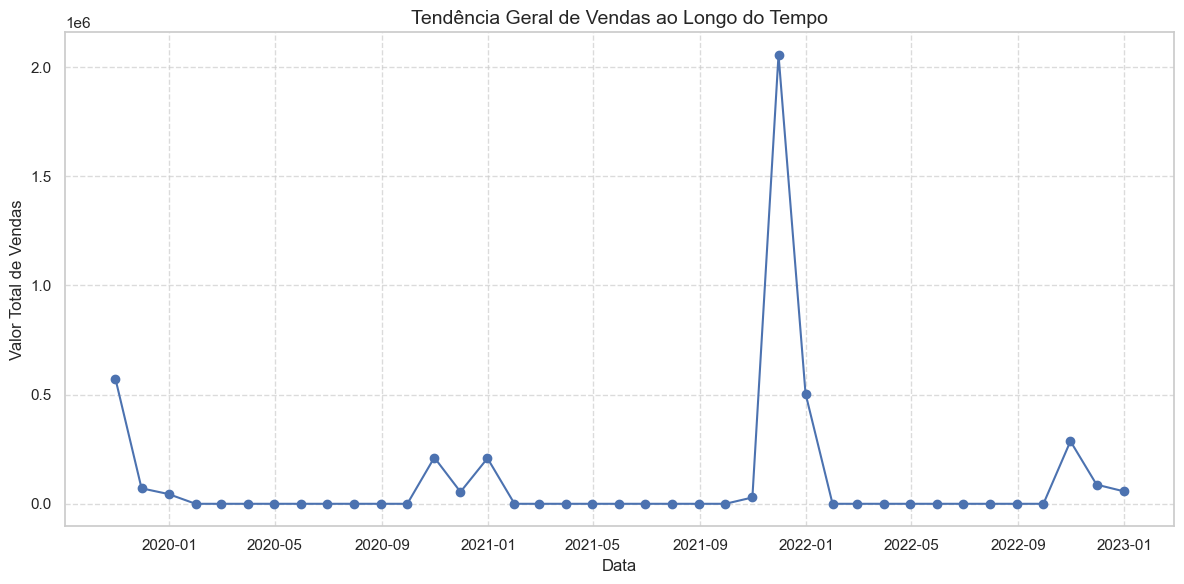

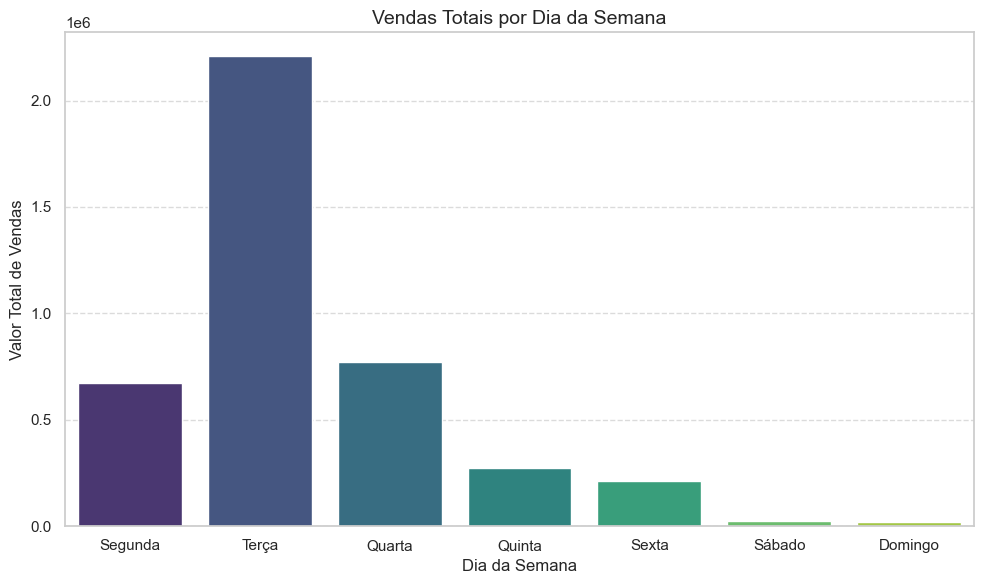

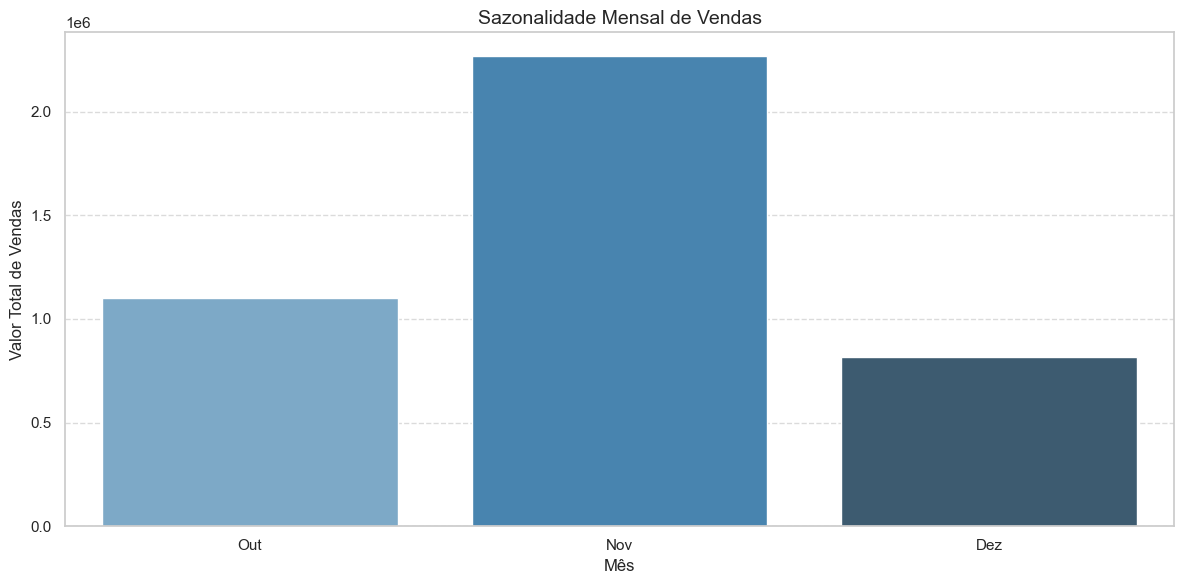

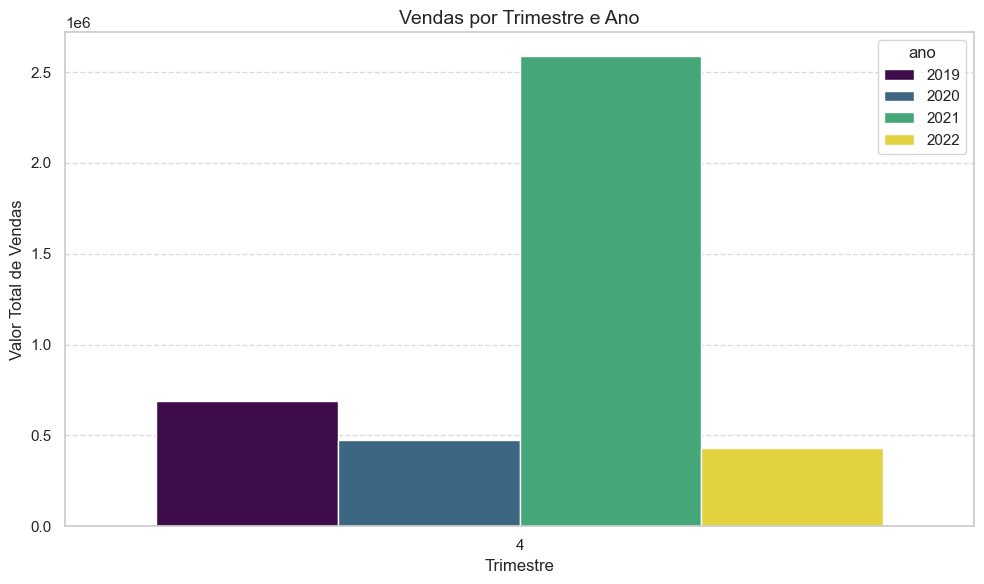

In [55]:
# 9.1 Criar coluna "ano_mes" a partir da coluna "data"
df_merged["ano_mes"] = df_merged["data"].dt.to_period("M")
vendas_por_mes = df_merged.groupby("ano_mes")["valor"].sum().reset_index()
vendas_por_mes["ano_mes_str"] = vendas_por_mes["ano_mes"].astype(str)

# Calcular média móvel de 3 meses para suavizar a série
vendas_por_mes["valor_rolling"] = vendas_por_mes["valor"].rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(14, 6))
sns.lineplot(data=vendas_por_mes, x="ano_mes_str", y="valor", marker="o", label="Valor Mensal")
sns.lineplot(data=vendas_por_mes, x="ano_mes_str", y="valor_rolling", marker="o", label="Média Móvel (3 meses)")
plt.xticks(rotation=45)
plt.title("Evolução Mensal das Vendas", fontsize=14)
plt.xlabel("Mês-Ano")
plt.ylabel("Valor Total de Vendas")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 9.2 Comparação ano a ano (mensalmente)
vendas_ano_mes = df_merged.groupby(["ano", "mes"])["valor"].sum().reset_index()
pivot_vendas = vendas_ano_mes.pivot(index="mes", columns="ano", values="valor")

plt.figure(figsize=(12, 6))
for ano in pivot_vendas.columns:
    plt.plot(pivot_vendas.index, pivot_vendas[ano], marker="o", label=str(ano))
plt.title("Comparação Mensal de Vendas por Ano", fontsize=14)
plt.xlabel("Mês")
plt.ylabel("Valor Total de Vendas")
plt.xticks(range(1, 13))
plt.legend(title="Ano")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 9.3 Decomposição de Séries Temporais para Análise de Sazonalidade
# Preparar dados para decomposição
vendas_mensais = df_merged.groupby(pd.Grouper(key='data', freq='M'))['valor'].sum().reset_index()
vendas_mensais = vendas_mensais.set_index('data')

# Verificar se temos dados suficientes para decomposição
if len(vendas_mensais) >= 12:  # Precisa de pelo menos 12 meses
    try:
        # Decomposição de série temporal
        decomposicao = seasonal_decompose(vendas_mensais, model='multiplicative', period=12)
        
        # Plotar decomposição
        plt.figure(figsize=(14, 12))
        
        plt.subplot(411)
        plt.plot(vendas_mensais, label='Original')
        plt.legend(loc='upper left')
        plt.title('Decomposição da Série Temporal de Vendas')
        
        plt.subplot(412)
        plt.plot(decomposicao.trend, label='Tendência')
        plt.legend(loc='upper left')
        
        plt.subplot(413)
        plt.plot(decomposicao.seasonal, label='Sazonalidade')
        plt.legend(loc='upper left')
        
        plt.subplot(414)
        plt.plot(decomposicao.resid, label='Resíduos')
        plt.legend(loc='upper left')
        
        plt.tight_layout()
        plt.show()
        
        # Extrair índices sazonais mensais
        indices_sazonais = decomposicao.seasonal[~decomposicao.seasonal.index.duplicated(keep='first')]
        indices_sazonais = indices_sazonais.sort_index()
        indices_sazonais = pd.DataFrame(indices_sazonais).reset_index()
        indices_sazonais['mes'] = indices_sazonais['data'].dt.month_name()
        
        # Plotar índices sazonais por mês
        plt.figure(figsize=(12, 6))
        sns.barplot(data=indices_sazonais, x='mes', y='seasonal', palette='coolwarm')
        plt.title('Índices Sazonais por Mês', fontsize=14)
        plt.xlabel('Mês')
        plt.ylabel('Índice Sazonal')
        plt.axhline(y=1, color='red', linestyle='--')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Não foi possível realizar a decomposição sazonal: {e}")
        print("Isso pode ocorrer devido à falta de dados suficientes ou irregularidades na série temporal.")
        
        # Alternativa: plotar apenas a tendência geral
        plt.figure(figsize=(12, 6))
        plt.plot(vendas_mensais.index, vendas_mensais['valor'], marker='o', linestyle='-')
        plt.title('Tendência Geral de Vendas ao Longo do Tempo', fontsize=14)
        plt.xlabel('Data')
        plt.ylabel('Valor Total de Vendas')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
else:
    print(f"Dados insuficientes para decomposição sazonal. São necessários pelo menos 12 meses, mas temos apenas {len(vendas_mensais)}.")
    
    # Alternativa: plotar apenas a tendência geral
    plt.figure(figsize=(12, 6))
    plt.plot(vendas_mensais.index, vendas_mensais['valor'], marker='o', linestyle='-')
    plt.title('Tendência Geral de Vendas ao Longo do Tempo', fontsize=14)
    plt.xlabel('Data')
    plt.ylabel('Valor Total de Vendas')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 9.4 Análise por dia da semana
# Garantir que a coluna dia_semana existe
if 'dia_semana' not in df_merged.columns:
    df_merged['dia_semana'] = df_merged['data'].dt.dayofweek

vendas_dia_semana = df_merged.groupby('dia_semana')['valor'].sum().reset_index()
dias = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
vendas_dia_semana['nome_dia'] = vendas_dia_semana['dia_semana'].apply(lambda x: dias[x] if 0 <= x < len(dias) else f'Dia {x}')

# Ordenar por dia da semana
vendas_dia_semana = vendas_dia_semana.sort_values('dia_semana')

plt.figure(figsize=(10, 6))
sns.barplot(data=vendas_dia_semana, x='nome_dia', y='valor', palette='viridis')
plt.title('Vendas Totais por Dia da Semana', fontsize=14)
plt.xlabel('Dia da Semana')
plt.ylabel('Valor Total de Vendas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 9.5 Análise por mês (independente do ano)
vendas_por_mes_geral = df_merged.groupby('mes')['valor'].sum().reset_index()
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
vendas_por_mes_geral['nome_mes'] = vendas_por_mes_geral['mes'].apply(lambda x: meses[x-1] if 1 <= x <= 12 else f'Mês {x}')

# Ordenar por mês
vendas_por_mes_geral = vendas_por_mes_geral.sort_values('mes')

plt.figure(figsize=(12, 6))
sns.barplot(data=vendas_por_mes_geral, x='nome_mes', y='valor', palette='Blues_d')
plt.title('Sazonalidade Mensal de Vendas', fontsize=14)
plt.xlabel('Mês')
plt.ylabel('Valor Total de Vendas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 9.6 Análise por trimestre
vendas_por_trimestre = df_merged.groupby(['ano', 'trimestre'])['valor'].sum().reset_index()

# Verificar se temos múltiplos anos e trimestres para fazer o pivot
if len(vendas_por_trimestre['ano'].unique()) > 1 and len(vendas_por_trimestre['trimestre'].unique()) > 1:
    pivot_trimestre = vendas_por_trimestre.pivot(index='trimestre', columns='ano', values='valor')
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_trimestre, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=.5)
    plt.title('Vendas por Trimestre e Ano', fontsize=14)
    plt.xlabel('Ano')
    plt.ylabel('Trimestre')
    plt.tight_layout()
    plt.show()
else:
    # Alternativa: mostrar um gráfico de barras simples
    plt.figure(figsize=(10, 6))
    sns.barplot(data=vendas_por_trimestre, x='trimestre', y='valor', hue='ano', palette='viridis')
    plt.title('Vendas por Trimestre e Ano', fontsize=14)
    plt.xlabel('Trimestre')
    plt.ylabel('Valor Total de Vendas')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 10. Estatísticas Descritivas Gerais

Nesta seção, calculamos as principais estatísticas descritivas dos dados de vendas, incluindo:
1. Estatísticas básicas da coluna "valor" (média, mediana, desvio padrão, etc.)
2. Análise de correlação entre variáveis numéricas
3. Testes estatísticos para comparar grupos de dados
4. Estatísticas descritivas por categoria (UF, porte, produto)
5. Análise da concentração de vendas (Curva ABC/Pareto)

Estas estatísticas fornecem uma visão geral quantitativa dos dados de vendas.

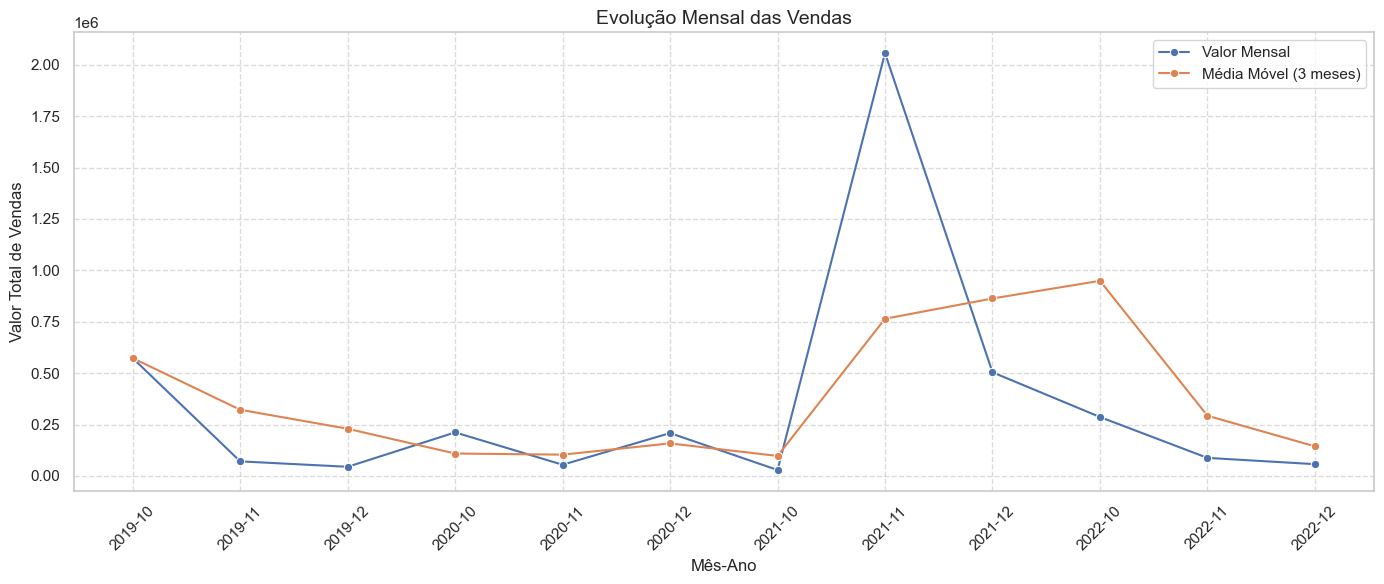

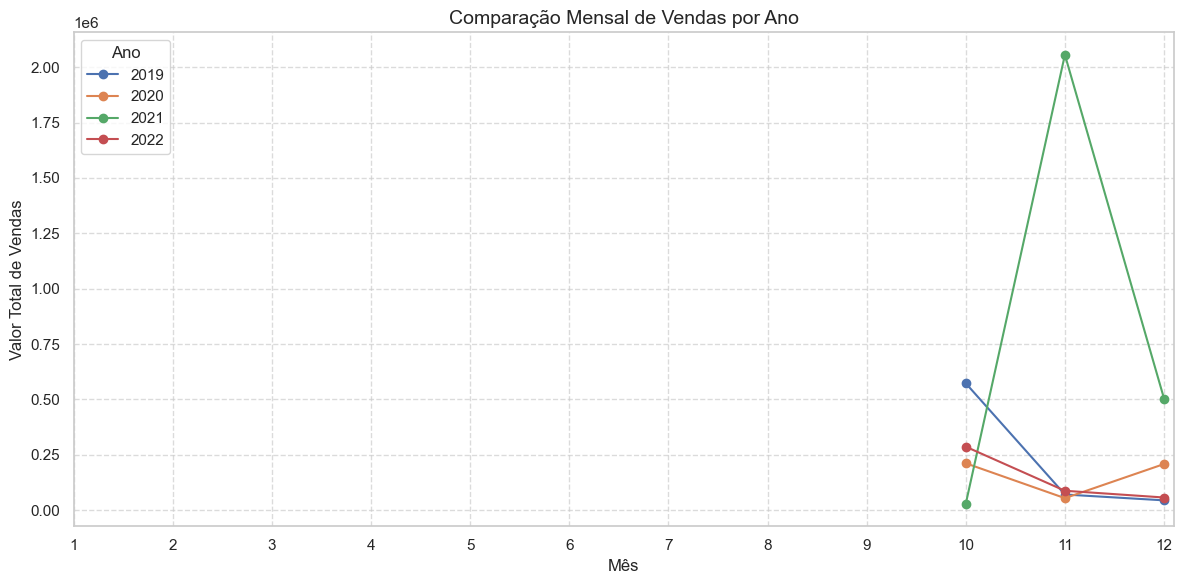

Não foi possível realizar a decomposição sazonal: Multiplicative seasonality is not appropriate for zero and negative values
Isso pode ocorrer devido à falta de dados suficientes ou irregularidades na série temporal.


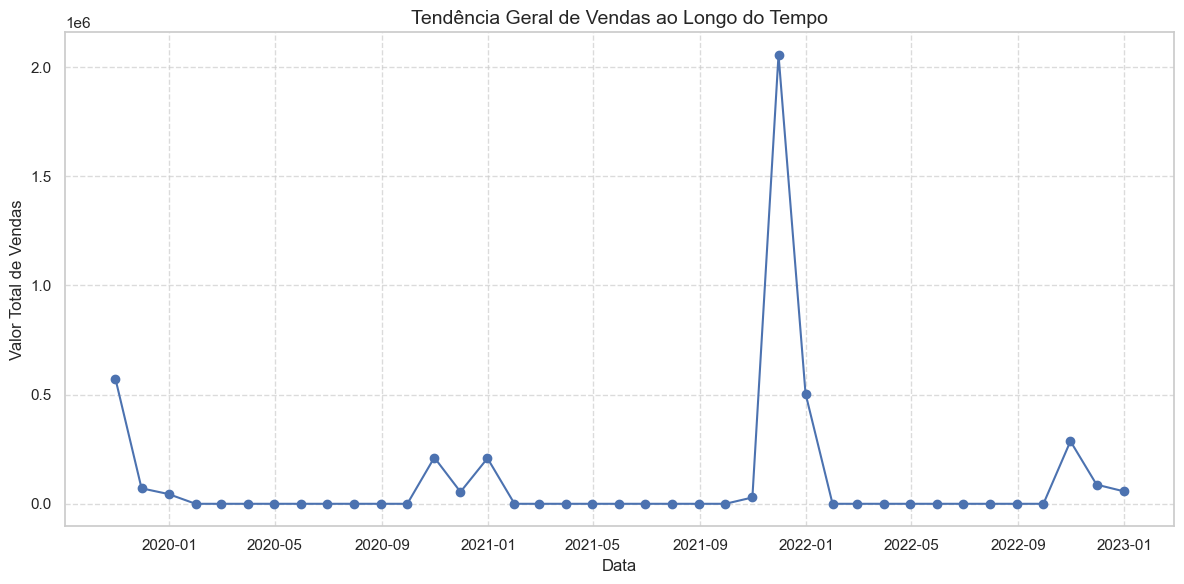

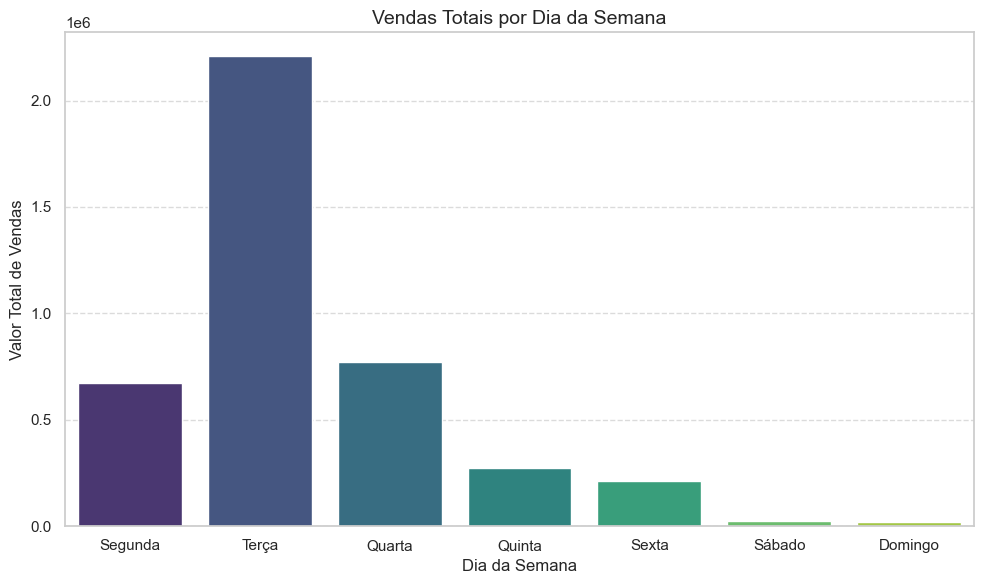

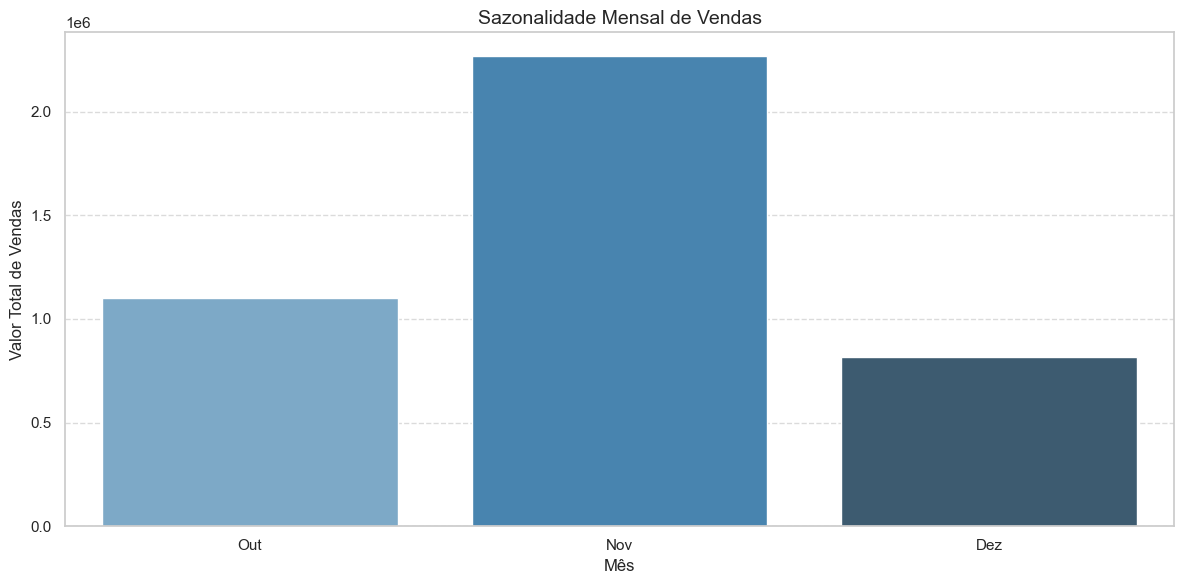

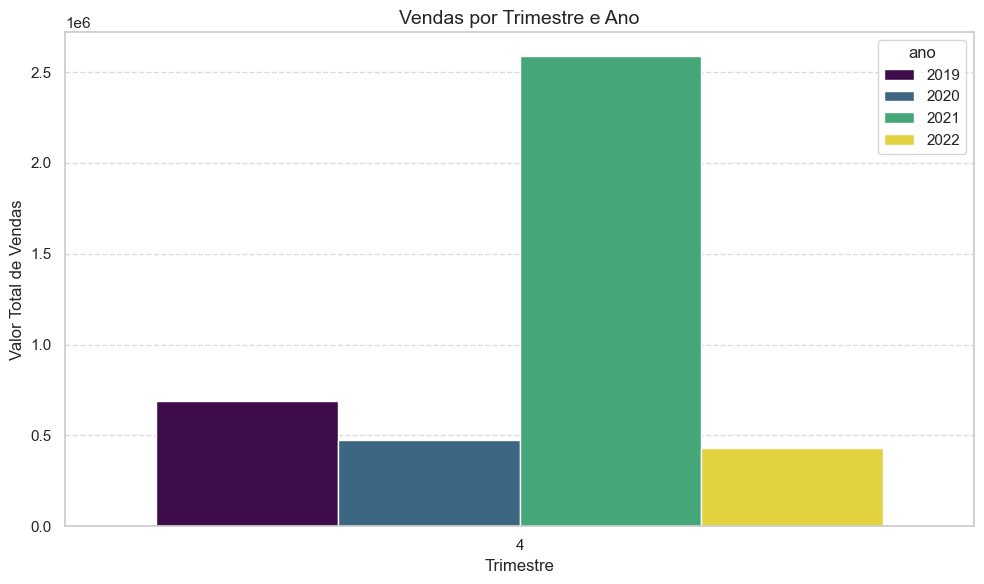

In [ ]:
# 9.1 Criar coluna "ano_mes" a partir da coluna "data"
df_merged["ano_mes"] = df_merged["data"].dt.to_period("M")
vendas_por_mes = df_merged.groupby("ano_mes")["valor"].sum().reset_index()
vendas_por_mes["ano_mes_str"] = vendas_por_mes["ano_mes"].astype(str)

# Calcular média móvel de 3 meses para suavizar a série
vendas_por_mes["valor_rolling"] = vendas_por_mes["valor"].rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(14, 6))
sns.lineplot(data=vendas_por_mes, x="ano_mes_str", y="valor", marker="o", label="Valor Mensal")
sns.lineplot(data=vendas_por_mes, x="ano_mes_str", y="valor_rolling", marker="o", label="Média Móvel (3 meses)")
plt.xticks(rotation=45)
plt.title("Evolução Mensal das Vendas", fontsize=14)
plt.xlabel("Mês-Ano")
plt.ylabel("Valor Total de Vendas")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 9.2 Comparação ano a ano (mensalmente)
vendas_ano_mes = df_merged.groupby(["ano", "mes"])["valor"].sum().reset_index()
pivot_vendas = vendas_ano_mes.pivot(index="mes", columns="ano", values="valor")

plt.figure(figsize=(12, 6))
for ano in pivot_vendas.columns:
    plt.plot(pivot_vendas.index, pivot_vendas[ano], marker="o", label=str(ano))
plt.title("Comparação Mensal de Vendas por Ano", fontsize=14)
plt.xlabel("Mês")
plt.ylabel("Valor Total de Vendas")
plt.xticks(range(1, 13))
plt.legend(title="Ano")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 9.3 Decomposição de Séries Temporais para Análise de Sazonalidade
# Preparar dados para decomposição
vendas_mensais = df_merged.groupby(pd.Grouper(key='data', freq='M'))['valor'].sum().reset_index()
vendas_mensais = vendas_mensais.set_index('data')

# Verificar se temos dados suficientes para decomposição
if len(vendas_mensais) >= 12:  # Precisa de pelo menos 12 meses
    try:
        # Decomposição de série temporal
        decomposicao = seasonal_decompose(vendas_mensais, model='multiplicative', period=12)
        
        # Plotar decomposição
        plt.figure(figsize=(14, 12))
        
        plt.subplot(411)
        plt.plot(vendas_mensais, label='Original')
        plt.legend(loc='upper left')
        plt.title('Decomposição da Série Temporal de Vendas')
        
        plt.subplot(412)
        plt.plot(decomposicao.trend, label='Tendência')
        plt.legend(loc='upper left')
        
        plt.subplot(413)
        plt.plot(decomposicao.seasonal, label='Sazonalidade')
        plt.legend(loc='upper left')
        
        plt.subplot(414)
        plt.plot(decomposicao.resid, label='Resíduos')
        plt.legend(loc='upper left')
        
        plt.tight_layout()
        plt.show()
        
        # Extrair índices sazonais mensais
        indices_sazonais = decomposicao.seasonal[~decomposicao.seasonal.index.duplicated(keep='first')]
        indices_sazonais = indices_sazonais.sort_index()
        indices_sazonais = pd.DataFrame(indices_sazonais).reset_index()
        indices_sazonais['mes'] = indices_sazonais['data'].dt.month_name()
        
        # Plotar índices sazonais por mês
        plt.figure(figsize=(12, 6))
        sns.barplot(data=indices_sazonais, x='mes', y='seasonal', palette='coolwarm')
        plt.title('Índices Sazonais por Mês', fontsize=14)
        plt.xlabel('Mês')
        plt.ylabel('Índice Sazonal')
        plt.axhline(y=1, color='red', linestyle='--')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Não foi possível realizar a decomposição sazonal: {e}")
        print("Isso pode ocorrer devido à falta de dados suficientes ou irregularidades na série temporal.")
        
        # Alternativa: plotar apenas a tendência geral
        plt.figure(figsize=(12, 6))
        plt.plot(vendas_mensais.index, vendas_mensais['valor'], marker='o', linestyle='-')
        plt.title('Tendência Geral de Vendas ao Longo do Tempo', fontsize=14)
        plt.xlabel('Data')
        plt.ylabel('Valor Total de Vendas')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
else:
    print(f"Dados insuficientes para decomposição sazonal. São necessários pelo menos 12 meses, mas temos apenas {len(vendas_mensais)}.")
    
    # Alternativa: plotar apenas a tendência geral
    plt.figure(figsize=(12, 6))
    plt.plot(vendas_mensais.index, vendas_mensais['valor'], marker='o', linestyle='-')
    plt.title('Tendência Geral de Vendas ao Longo do Tempo', fontsize=14)
    plt.xlabel('Data')
    plt.ylabel('Valor Total de Vendas')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 9.4 Análise por dia da semana
# Garantir que a coluna dia_semana existe
if 'dia_semana' not in df_merged.columns:
    df_merged['dia_semana'] = df_merged['data'].dt.dayofweek

vendas_dia_semana = df_merged.groupby('dia_semana')['valor'].sum().reset_index()
dias = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
vendas_dia_semana['nome_dia'] = vendas_dia_semana['dia_semana'].apply(lambda x: dias[x] if 0 <= x < len(dias) else f'Dia {x}')

# Ordenar por dia da semana
vendas_dia_semana = vendas_dia_semana.sort_values('dia_semana')

plt.figure(figsize=(10, 6))
sns.barplot(data=vendas_dia_semana, x='nome_dia', y='valor', palette='viridis')
plt.title('Vendas Totais por Dia da Semana', fontsize=14)
plt.xlabel('Dia da Semana')
plt.ylabel('Valor Total de Vendas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 9.5 Análise por mês (independente do ano)
vendas_por_mes_geral = df_merged.groupby('mes')['valor'].sum().reset_index()
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
vendas_por_mes_geral['nome_mes'] = vendas_por_mes_geral['mes'].apply(lambda x: meses[x-1] if 1 <= x <= 12 else f'Mês {x}')

# Ordenar por mês
vendas_por_mes_geral = vendas_por_mes_geral.sort_values('mes')

plt.figure(figsize=(12, 6))
sns.barplot(data=vendas_por_mes_geral, x='nome_mes', y='valor', palette='Blues_d')
plt.title('Sazonalidade Mensal de Vendas', fontsize=14)
plt.xlabel('Mês')
plt.ylabel('Valor Total de Vendas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 9.6 Análise por trimestre
vendas_por_trimestre = df_merged.groupby(['ano', 'trimestre'])['valor'].sum().reset_index()

# Verificar se temos múltiplos anos e trimestres para fazer o pivot
if len(vendas_por_trimestre['ano'].unique()) > 1 and len(vendas_por_trimestre['trimestre'].unique()) > 1:
    pivot_trimestre = vendas_por_trimestre.pivot(index='trimestre', columns='ano', values='valor')
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_trimestre, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=.5)
    plt.title('Vendas por Trimestre e Ano', fontsize=14)
    plt.xlabel('Ano')
    plt.ylabel('Trimestre')
    plt.tight_layout()
    plt.show()
else:
    # Alternativa: mostrar um gráfico de barras simples
    plt.figure(figsize=(10, 6))
    sns.barplot(data=vendas_por_trimestre, x='trimestre', y='valor', hue='ano', palette='viridis')
    plt.title('Vendas por Trimestre e Ano', fontsize=14)
    plt.xlabel('Trimestre')
    plt.ylabel('Valor Total de Vendas')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 10. Estatísticas Descritivas Gerais

Nesta seção, calculamos as principais estatísticas descritivas dos dados de vendas, incluindo:
1. Estatísticas básicas da coluna "valor" (média, mediana, desvio padrão, etc.)
2. Análise de correlação entre variáveis numéricas
3. Testes estatísticos para comparar grupos de dados
4. Estatísticas descritivas por categoria (UF, porte, produto)
5. Análise da concentração de vendas (Curva ABC/Pareto)

Estas estatísticas fornecem uma visão geral quantitativa dos dados de vendas.

=== Estatísticas descritivas de 'valor' ===


count      1814.000000
mean       2306.914410
std       18824.798219
min           3.140000
25%          50.620000
50%         116.840000
75%         267.847500
max      280884.240000
Name: valor, dtype: float64

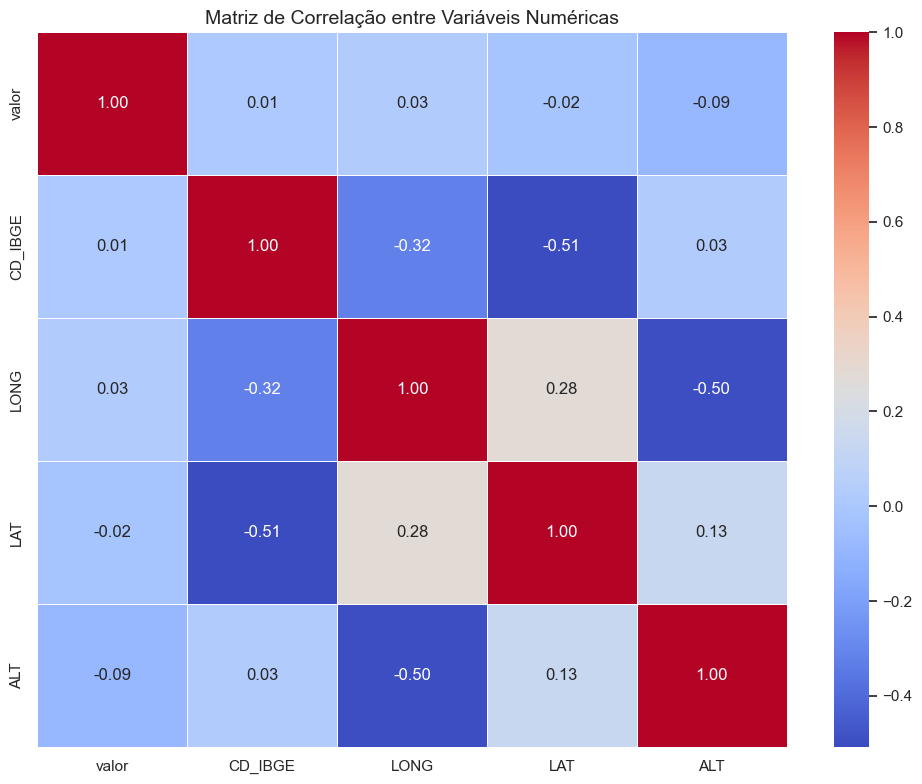


=== Teste ANOVA: Comparação de valores entre diferentes portes de empresa ===
Estatística F: 3.1737
Valor p: 0.0421
Diferença estatisticamente significativa: True

Comparação entre pares de portes (teste t):
Pequena vs Grande: t=-4.9015, p=0.0000, significativo: True
Pequena vs Media: t=-2.8951, p=0.0041, significativo: True
Grande vs Media: t=4.6276, p=0.0000, significativo: True

=== Estatísticas descritivas por UF ===


,SG_UF,count,mean,std,min,25%,50%,75%,max
0,AM,1.0,385.000000,NaN,385.00,385.00,385.00,385.000,385.00
1,BA,2.0,448.000000,0.000000,448.00,448.00,448.00,448.000,448.00
2,CE,4.0,1908.000000,0.000000,1908.00,1908.00,1908.00,1908.000,1908.00
3,DF,4.0,40.000000,0.000000,40.00,40.00,40.00,40.000,40.00
4,GO,1.0,263.400000,NaN,263.40,263.40,263.40,263.400,263.40
5,MS,7.0,3562.000000,0.000000,3562.00,3562.00,3562.00,3562.000,3562.00
6,PR,27.0,1339.664815,2093.418212,29.88,103.76,472.00,605.000,5760.00
7,RS,19.0,21051.842105,12374.878182,897.00,14573.50,28250.00,28250.000,28250.00
8,SC,1727.0,2140.151847,19146.841945,3.14,49.90,113.37,224.285,280884.24
9,SP,22.0,830.643182,664.978765,40.15,75.00,1168.50,1440.000,1440.00



Top 5 UFs por valor médio:


,SG_UF,mean
7,RS,21051.842105
5,MS,3562.000000
8,SC,2140.151847
2,CE,1908.000000
6,PR,1339.664815



=== Top 10 produtos por valor total de vendas ===


,produto,valor_total,num_vendas,valor_medio
4,produto_04,2588946.07,31,83514.389355
22,produto_35,395500.00,14,28250.000000
0,produto_00,306684.64,1344,228.187976
21,produto_28,177321.45,3,59107.150000
30,produto_53,155800.00,1,155800.000000
15,produto_17,125742.10,16,7858.881250
16,produto_18,68272.90,7,9753.271429
11,produto_12,55310.00,23,2404.782609
10,produto_11,49081.80,20,2454.090000
3,produto_03,37820.13,63,600.319524


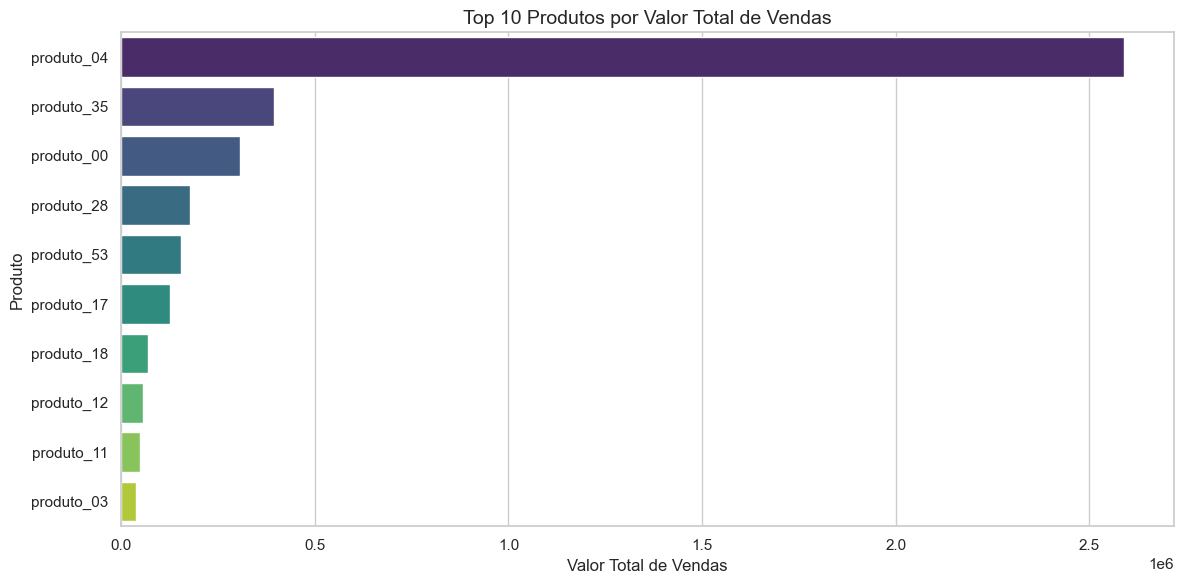


=== Análise de Pareto (Curva ABC) ===
Total de produtos: 35

Distribuição dos produtos por classe:


,classe,num_produtos
0,C,25
1,B,7
2,A,3



Distribuição do valor por classe:


,classe,valor_total
0,A,3291130.71
1,B,669348.38
2,C,224263.65


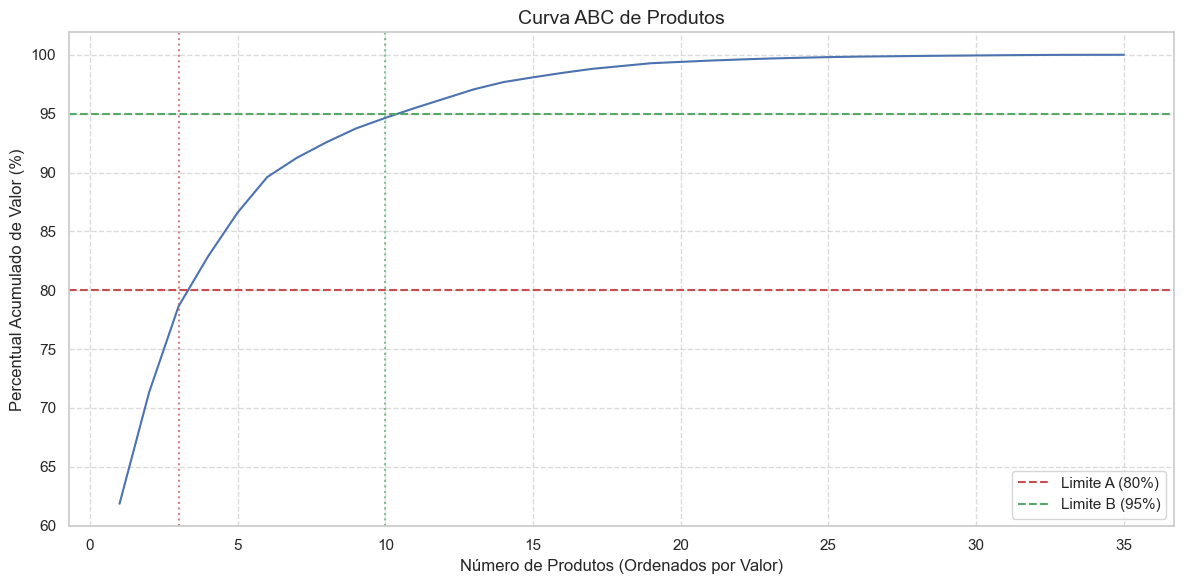

In [56]:
# 10.1 Estatísticas descritivas gerais da coluna "valor"
print("=== Estatísticas descritivas de 'valor' ===")
display(df_merged["valor"].describe())

# 10.2 Análise de Correlação entre Variáveis

# Selecionar apenas colunas numéricas para correlação (excluindo chaves/IDs)
colunas_numericas = df_merged.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Filtrando colunas que provavelmente não são relevantes (códigos, etc)
colunas_correlacao = [col for col in colunas_numericas if not any(x in col.lower() for x in ['codigo', 'id', 'cd7'])]

# Verificar se temos variáveis suficientes para correlação
if len(colunas_correlacao) >= 2:
    matriz_corr = df_merged[colunas_correlacao].corr()
    
    # Plotar mapa de calor da correlação
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Matriz de Correlação entre Variáveis Numéricas', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Não há variáveis numéricas suficientes para análise de correlação.")

# 10.3 Testes Estatísticos

# Exemplo: comparar valores de vendas entre diferentes portes de empresa
if 'porte' in df_merged.columns and len(df_merged['porte'].unique()) >= 2:
    print("\n=== Teste ANOVA: Comparação de valores entre diferentes portes de empresa ===")
    portes = df_merged['porte'].unique()
    
    from scipy import stats
    
    grupos = [df_merged[df_merged['porte'] == p]['valor'].dropna() for p in portes]
    
    # Realizar teste ANOVA para comparar médias
    try:
        f_stat, p_value = stats.f_oneway(*grupos)
        
        print(f"Estatística F: {f_stat:.4f}")
        print(f"Valor p: {p_value:.4f}")
        print(f"Diferença estatisticamente significativa: {p_value < 0.05}")
        
        if p_value < 0.05:
            print("\nComparação entre pares de portes (teste t):")
            for i, p1 in enumerate(portes):
                for j, p2 in enumerate(portes):
                    if i < j:  # Evitar comparações duplicadas
                        grupo1 = df_merged[df_merged['porte'] == p1]['valor'].dropna()
                        grupo2 = df_merged[df_merged['porte'] == p2]['valor'].dropna()
                        
                        t_stat, p_val = stats.ttest_ind(grupo1, grupo2, equal_var=False)
                        print(f"{p1} vs {p2}: t={t_stat:.4f}, p={p_val:.4f}, significativo: {p_val < 0.05}")
    except Exception as e:
        print(f"Erro ao realizar teste ANOVA: {e}")
        print("Isso pode ocorrer se os grupos forem muito pequenos ou se houver problemas com os dados.")

# 10.4 Estatísticas por categoria
# Por UF
if 'SG_UF' in df_merged.columns:
    stats_por_uf = df_merged.groupby('SG_UF')['valor'].describe().reset_index()
    print("\n=== Estatísticas descritivas por UF ===")
    display(stats_por_uf)
    
    # Top 5 UFs por média
    top_ufs_media = stats_por_uf.sort_values('mean', ascending=False).head(5)
    print("\nTop 5 UFs por valor médio:")
    display(top_ufs_media[['SG_UF', 'mean']])

# Por produto (top 10 produtos mais vendidos)
if 'produto' in df_merged.columns:
    vendas_por_produto = df_merged.groupby('produto')['valor'].agg(['sum', 'count', 'mean']).reset_index()
    vendas_por_produto.columns = ['produto', 'valor_total', 'num_vendas', 'valor_medio']
    vendas_por_produto = vendas_por_produto.sort_values('valor_total', ascending=False)
    
    print("\n=== Top 10 produtos por valor total de vendas ===")
    display(vendas_por_produto.head(10))
    
    # Visualizar top 10 produtos
    plt.figure(figsize=(12, 6))
    top10 = vendas_por_produto.head(10)
    sns.barplot(data=top10, x='valor_total', y='produto', palette='viridis')
    plt.title('Top 10 Produtos por Valor Total de Vendas', fontsize=14)
    plt.xlabel('Valor Total de Vendas')
    plt.ylabel('Produto')
    plt.tight_layout()
    plt.show()

# 10.5 Análise da concentração de vendas (Curva ABC/Pareto)
if 'produto' in df_merged.columns:
    # Calcular o valor total para classificação
    total_valor = vendas_por_produto['valor_total'].sum()
    
    # Ordenar produtos por valor e calcular o percentual cumulativo
    vendas_por_produto = vendas_por_produto.sort_values('valor_total', ascending=False)
    vendas_por_produto['perc_valor'] = vendas_por_produto['valor_total'] / total_valor * 100
    vendas_por_produto['perc_acumulado'] = vendas_por_produto['perc_valor'].cumsum()
    
    # Classificar em A, B e C
    vendas_por_produto['classe'] = 'C'
    vendas_por_produto.loc[vendas_por_produto['perc_acumulado'] <= 80, 'classe'] = 'A'
    vendas_por_produto.loc[(vendas_por_produto['perc_acumulado'] > 80) & 
                           (vendas_por_produto['perc_acumulado'] <= 95), 'classe'] = 'B'
    
    # Contagem de produtos por classe
    contagem_classes = vendas_por_produto['classe'].value_counts().reset_index()
    contagem_classes.columns = ['classe', 'num_produtos']
    
    # Valor por classe
    valor_por_classe = vendas_por_produto.groupby('classe')['valor_total'].sum().reset_index()
    
    print("\n=== Análise de Pareto (Curva ABC) ===")
    print(f"Total de produtos: {len(vendas_por_produto)}")
    
    print("\nDistribuição dos produtos por classe:")
    display(contagem_classes)
    
    print("\nDistribuição do valor por classe:")
    display(valor_por_classe)
    
    # Visualizar curva ABC
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(vendas_por_produto) + 1), vendas_por_produto['perc_acumulado'], 'b-')
    plt.axhline(y=80, color='r', linestyle='--', label='Limite A (80%)')
    plt.axhline(y=95, color='g', linestyle='--', label='Limite B (95%)')
    
    # Adicionar linhas verticais para separar as classes
    limite_a = vendas_por_produto[vendas_por_produto['classe'] == 'A'].shape[0]
    limite_b = vendas_por_produto[(vendas_por_produto['classe'] == 'A') | 
                                 (vendas_por_produto['classe'] == 'B')].shape[0]
    
    plt.axvline(x=limite_a, color='r', linestyle=':', alpha=0.7)
    plt.axvline(x=limite_b, color='g', linestyle=':', alpha=0.7)
    
    plt.title('Curva ABC de Produtos', fontsize=14)
    plt.xlabel('Número de Produtos (Ordenados por Valor)')
    plt.ylabel('Percentual Acumulado de Valor (%)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 11. Estatísticas Descritivas por Tempo

Nesta seção, analisamos o comportamento das vendas ao longo do tempo, calculando estatísticas por diferentes períodos:
1. Estatísticas por ano
2. Estatísticas por mês
3. Estatísticas por trimestre
4. Análise de crescimento/decrescimento entre períodos
5. Análise de tendência de ticket médio ao longo do tempo

Estas análises permitem identificar tendências de longo prazo, sazonalidade e padrões de consumo ao longo do tempo.

=== Estatísticas de 'valor' por ano ===


,count,mean,std,min,25%,50%,75%,max
ano,,,,,,,,
2019,541.0,1272.648318,8635.913380,3.14,44.2500,100.75,150.0000,76245.87
2020,483.0,983.260207,5915.354344,4.99,42.5750,104.78,281.6700,93533.75
2021,402.0,6441.100522,36986.365533,3.99,52.3800,112.44,394.9950,280884.24
2022,388.0,1113.409562,8494.848128,7.99,75.7575,159.08,475.8475,155800.00



=== Crescimento anual de vendas ===


,ano,valor,crescimento
0,2019,688502.74,NaN
1,2020,474914.68,-31.022107
2,2021,2589322.41,445.218440
3,2022,432002.91,-83.315986


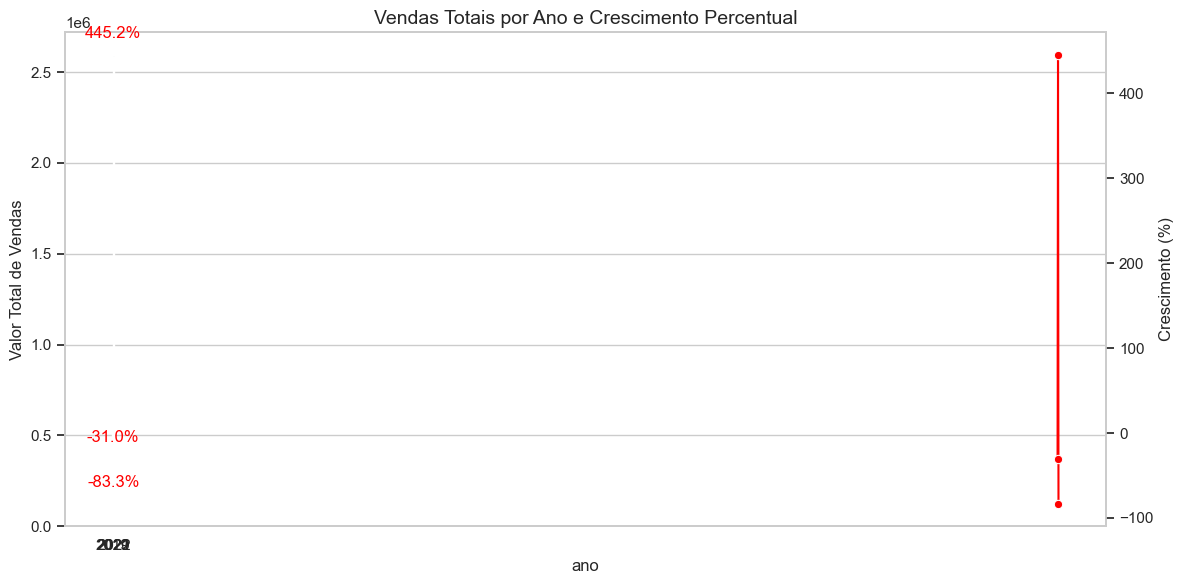

=== Estatísticas de 'valor' por mês ===


,count,mean,std,min,25%,50%,75%,max
mes,,,,,,,,
10,660.0,1667.529742,10414.205886,3.14,49.900,115.365,282.530,155800.00
11,567.0,4002.476032,31101.188035,4.99,56.385,124.630,227.900,280884.24
12,587.0,1388.022487,6004.517076,3.99,45.230,110.690,276.175,93533.75


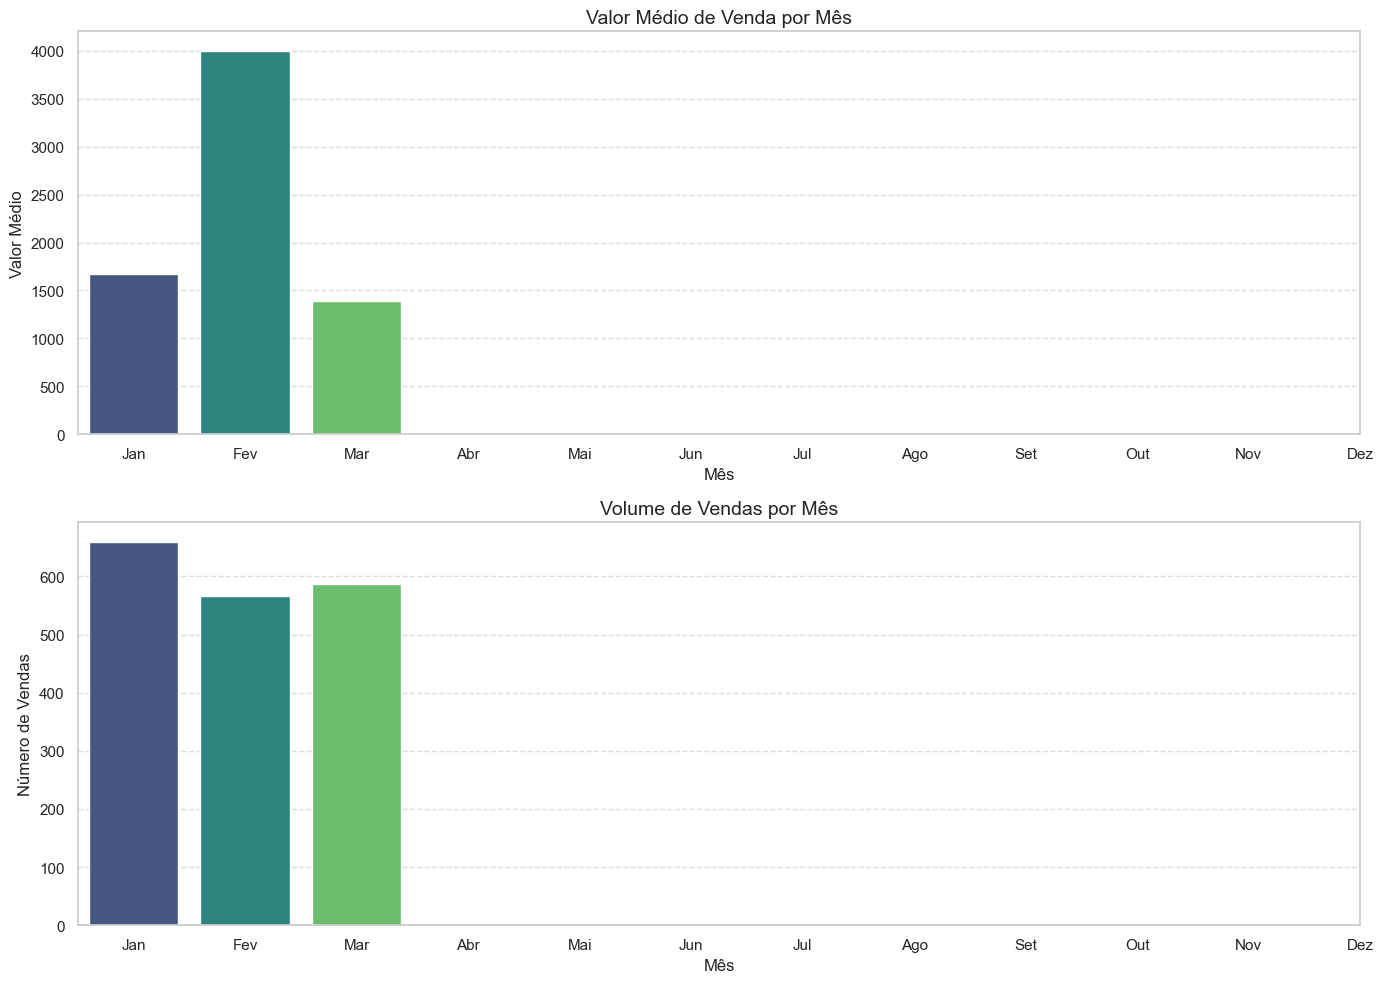

=== Estatísticas de 'valor' por trimestre ===


,ano,trimestre,count,mean,std,min,25%,50%,75%,max
0,2019,4,541.0,1272.648318,8635.913380,3.14,44.2500,100.75,150.0000,76245.87
1,2020,4,483.0,983.260207,5915.354344,4.99,42.5750,104.78,281.6700,93533.75
2,2021,4,402.0,6441.100522,36986.365533,3.99,52.3800,112.44,394.9950,280884.24
3,2022,4,388.0,1113.409562,8494.848128,7.99,75.7575,159.08,475.8475,155800.00


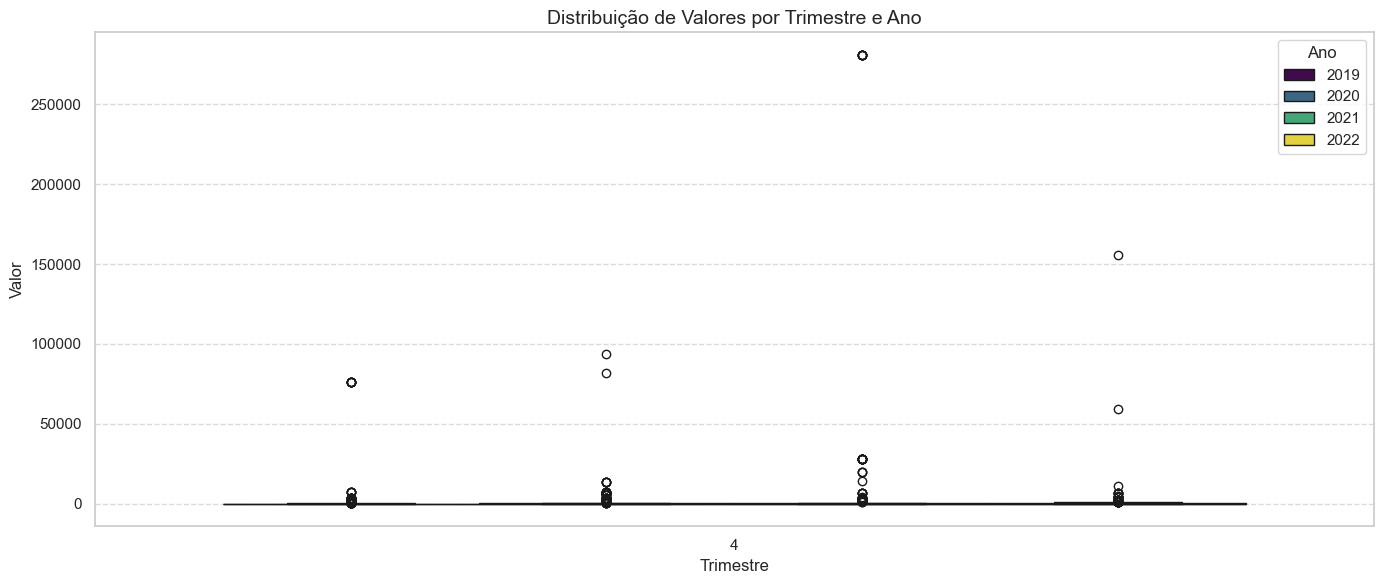

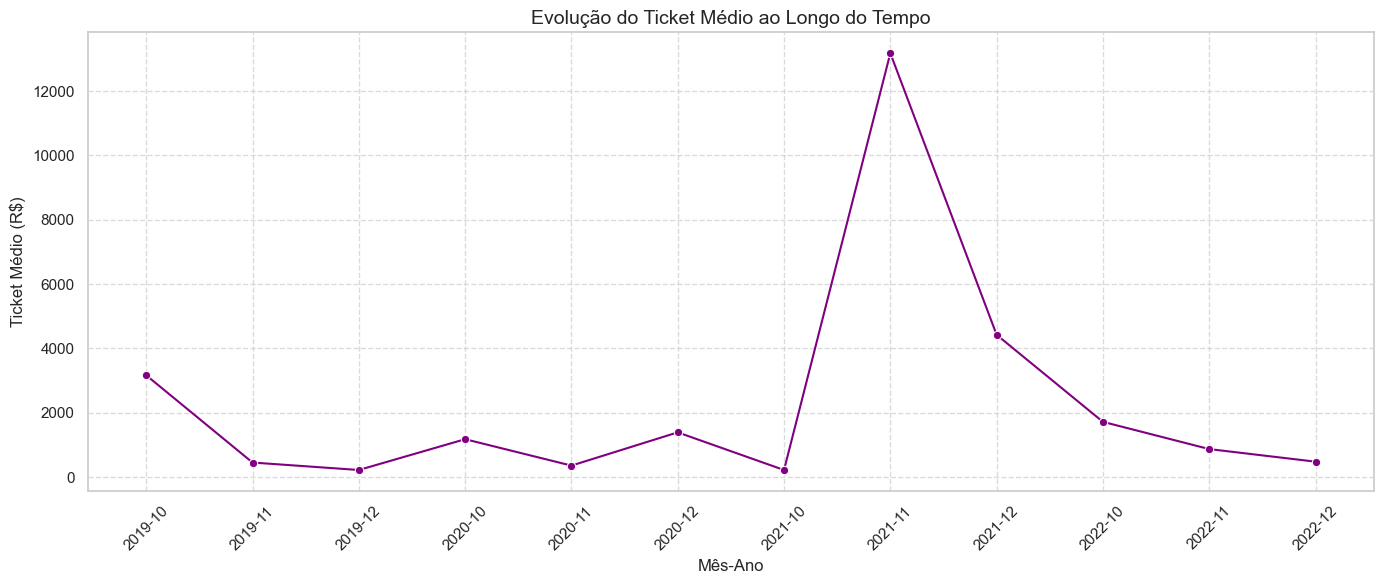

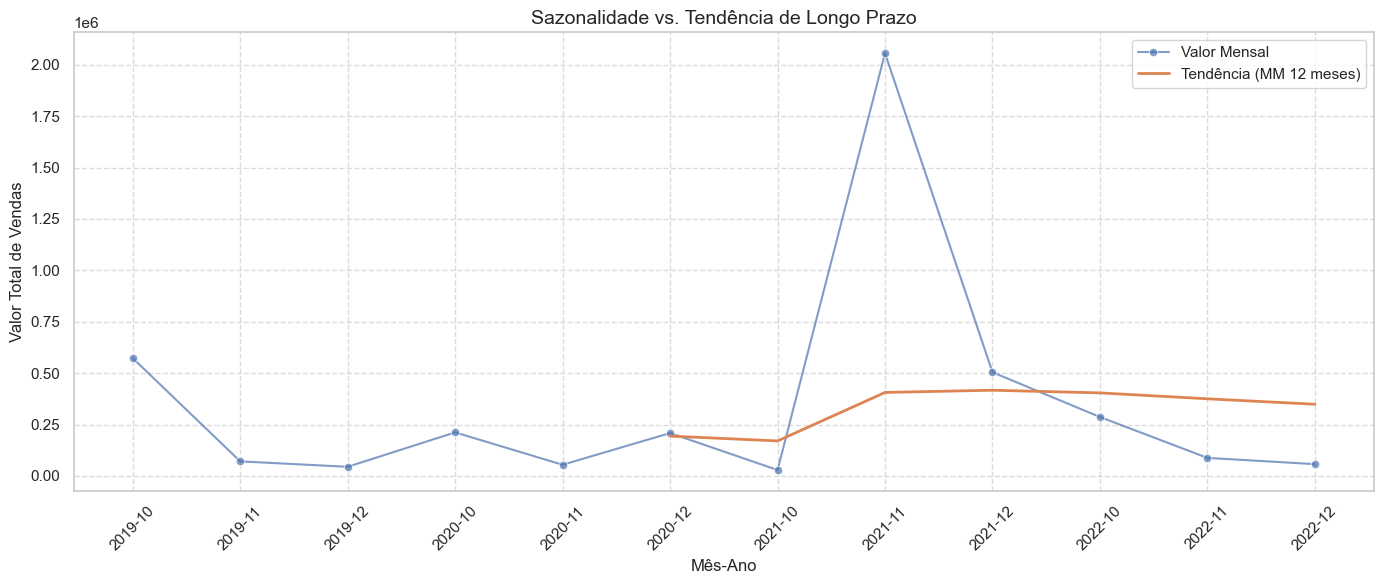

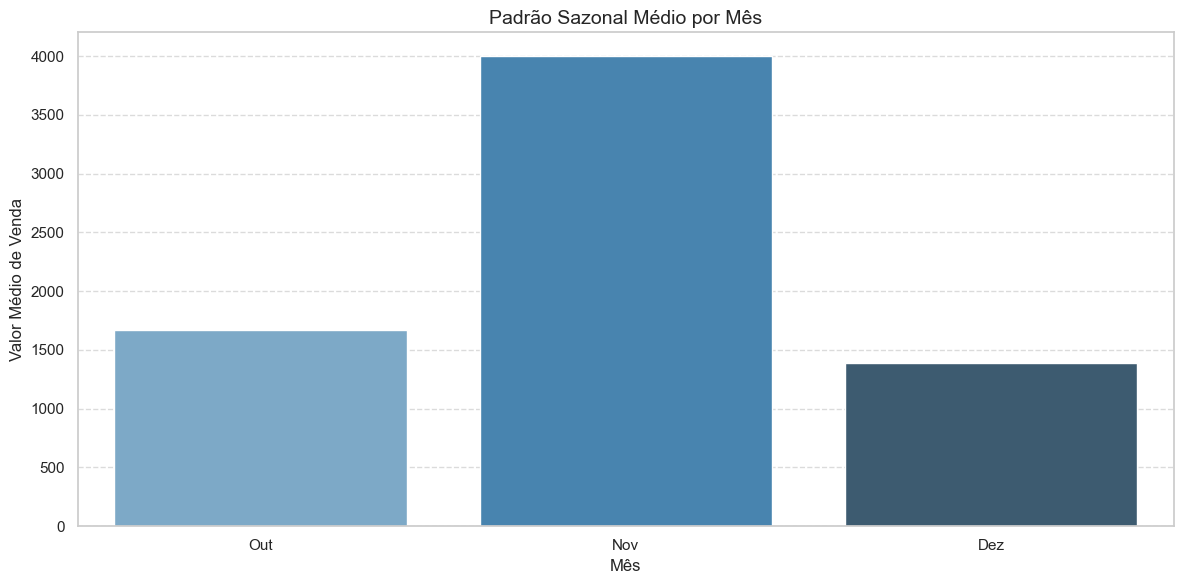

In [57]:
# 11.1 Estatísticas por ano
print("=== Estatísticas de 'valor' por ano ===")
stats_ano = df_merged.groupby("ano")["valor"].describe()
display(stats_ano)

# Calcular crescimento ano a ano
valor_por_ano = df_merged.groupby("ano")["valor"].sum().reset_index()
valor_por_ano["crescimento"] = valor_por_ano["valor"].pct_change() * 100

print("\n=== Crescimento anual de vendas ===")
display(valor_por_ano)

# Visualizar crescimento anual
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(111)
sns.barplot(data=valor_por_ano, x="ano", y="valor", palette="Blues_d", ax=ax1)
ax1.set_ylabel("Valor Total de Vendas")
ax1.set_title("Vendas Totais por Ano e Crescimento Percentual", fontsize=14)

# Adicionar linha de crescimento
ax2 = ax1.twinx()
sns.lineplot(data=valor_por_ano[1:], x="ano", y="crescimento", marker="o", color="red", ax=ax2)
ax2.set_ylabel("Crescimento (%)")
ax2.grid(False)

# Adicionar rótulos de crescimento
for i, row in valor_por_ano[1:].iterrows():
    if not pd.isna(row["crescimento"]):
        ax2.annotate(f"{row['crescimento']:.1f}%", 
                    xy=(i-1, row["crescimento"]), 
                    xytext=(0, 10),
                    textcoords="offset points",
                    ha="center", va="bottom",
                    color="red")

plt.tight_layout()
plt.show()

# 11.2 Estatísticas por mês (média, etc.)
print("=== Estatísticas de 'valor' por mês ===")
stats_mes = df_merged.groupby("mes")["valor"].describe()
display(stats_mes)

# Visualizar estatísticas mensais
plt.figure(figsize=(14, 10))

# Valor médio por mês
plt.subplot(2, 1, 1)
sns.barplot(data=df_merged, x="mes", y="valor", estimator=np.mean, ci=None, palette="viridis")
plt.title("Valor Médio de Venda por Mês", fontsize=14)
plt.xlabel("Mês")
plt.ylabel("Valor Médio")
plt.xticks(range(12), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Volume de vendas por mês
plt.subplot(2, 1, 2)
sns.countplot(data=df_merged, x="mes", palette="viridis")
plt.title("Volume de Vendas por Mês", fontsize=14)
plt.xlabel("Mês")
plt.ylabel("Número de Vendas")
plt.xticks(range(12), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 11.3 Estatísticas por trimestre
print("=== Estatísticas de 'valor' por trimestre ===")
stats_trimestre = df_merged.groupby(["ano", "trimestre"])["valor"].describe().reset_index()
display(stats_trimestre)

# Visualizar medidas estatísticas por trimestre (boxplot)
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_merged, x="trimestre", y="valor", hue="ano", palette="viridis")
plt.title("Distribuição de Valores por Trimestre e Ano", fontsize=14)
plt.xlabel("Trimestre")
plt.ylabel("Valor")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Ano")
plt.tight_layout()
plt.show()

# 11.4 Análise de tendência de ticket médio ao longo do tempo
# Agrupar por mês-ano e calcular o ticket médio
ticket_medio_tempo = df_merged.groupby("ano_mes").agg({
    "valor": ["sum", "count", "mean"]
}).reset_index()

ticket_medio_tempo.columns = ["ano_mes", "valor_total", "num_vendas", "ticket_medio"]
ticket_medio_tempo["ano_mes_str"] = ticket_medio_tempo["ano_mes"].astype(str)

# Plotar evolução do ticket médio
plt.figure(figsize=(14, 6))
sns.lineplot(data=ticket_medio_tempo, x="ano_mes_str", y="ticket_medio", marker="o", color="purple")
plt.title("Evolução do Ticket Médio ao Longo do Tempo", fontsize=14)
plt.xlabel("Mês-Ano")
plt.ylabel("Ticket Médio (R$)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# 11.5 Análise de sazonalidade vs. tendência de longo prazo
# Calcular o valor médio mensal para visualizar a sazonalidade
valor_medio_mes = df_merged.groupby("mes")["valor"].mean().reset_index()
valor_medio_mes["nome_mes"] = valor_medio_mes["mes"].apply(lambda x: ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'][x-1] if 1 <= x <= 12 else f'Mês {x}')

# Ordenar por mês
valor_medio_mes = valor_medio_mes.sort_values("mes")

# Calcular a tendência de longo prazo (média móvel anual)
if len(vendas_por_mes) >= 12:
    vendas_por_mes["media_movel_anual"] = vendas_por_mes["valor"].rolling(window=12, min_periods=6).mean()
    
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=vendas_por_mes, x="ano_mes_str", y="valor", marker="o", label="Valor Mensal", alpha=0.7)
    sns.lineplot(data=vendas_por_mes, x="ano_mes_str", y="media_movel_anual", linewidth=2, label="Tendência (MM 12 meses)")
    plt.title("Sazonalidade vs. Tendência de Longo Prazo", fontsize=14)
    plt.xlabel("Mês-Ano")
    plt.ylabel("Valor Total de Vendas")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Visualizar padrão sazonal médio mensal
plt.figure(figsize=(12, 6))
sns.barplot(data=valor_medio_mes, x="nome_mes", y="valor", palette="Blues_d")
plt.title("Padrão Sazonal Médio por Mês", fontsize=14)
plt.xlabel("Mês")
plt.ylabel("Valor Médio de Venda")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 12. Análise de Padrões por Região e Porte

Nesta seção, exploramos padrões de vendas segmentados por características geográficas e de porte empresarial:
1. Análise regional (por UF, mesorregião e microrregião)
2. Padrões de compra por porte de empresa
3. Combinação de fatores regionais e porte para identificar nichos
4. Análise de valor médio de venda por região e porte

Esta análise ajuda a equipe de marketing a identificar oportunidades de segmentação geográfica e por perfil de cliente.

=== Análise de vendas por UF ===


,SG_UF,valor_total,valor_medio,num_vendas,num_clientes,ticket_medio
8,SC,3696042.24,2140.151847,1727,590,2140.151847
7,RS,399985.00,21051.842105,19,2,21051.842105
6,PR,36170.95,1339.664815,27,8,1339.664815
5,MS,24934.00,3562.000000,7,1,3562.000000
9,SP,18274.15,830.643182,22,4,830.643182
2,CE,7632.00,1908.000000,4,1,1908.000000
1,BA,896.00,448.000000,2,1,448.000000
0,AM,385.00,385.000000,1,1,385.000000
4,GO,263.40,263.400000,1,1,263.400000
3,DF,160.00,40.000000,4,1,40.000000


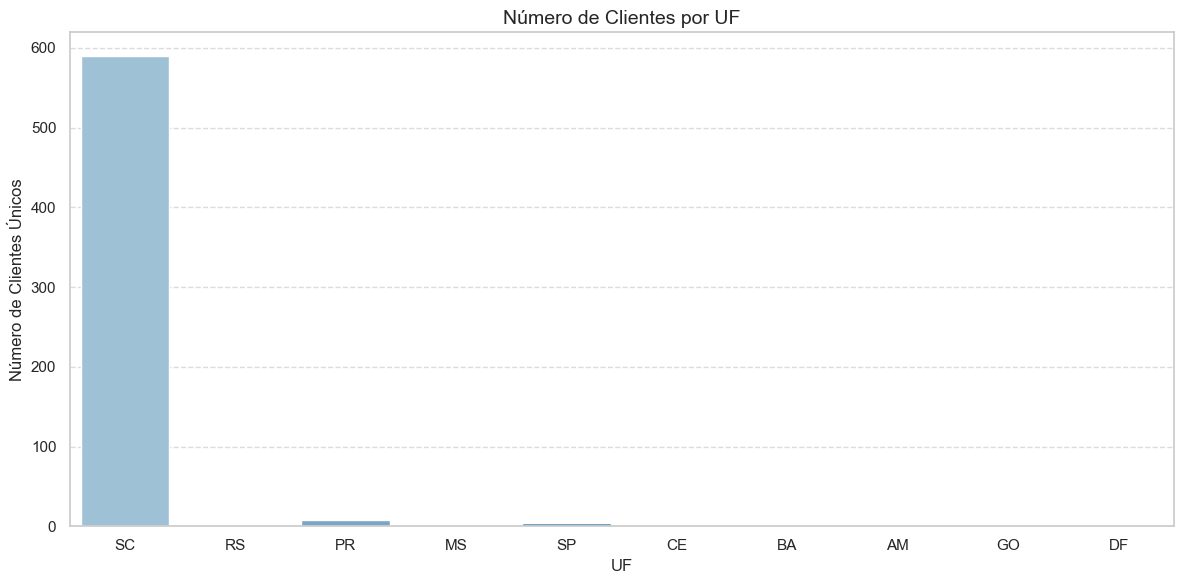


=== Top 15 mesorregiões por valor total de vendas ===


,SG_UF,NM_MESO,valor_total,valor_medio,num_vendas,num_clientes,ticket_medio
16,SC,Vale do Itajaí,2812346.17,6061.090884,464,135,6061.090884
10,RS,Metropolitana de Porto Alegre,399985.00,21051.842105,19,2,21051.842105
11,SC,Grande Florianópolis,340178.69,1726.795381,197,60,1726.795381
12,SC,Norte Catarinense,263081.45,506.900674,519,175,506.900674
13,SC,Oeste Catarinense,136159.00,418.950769,325,128,418.950769
15,SC,Sul Catarinense,129295.90,1124.312174,115,49,1124.312174
5,MS,Centro Norte de Mato Grosso do Sul,24934.00,3562.000000,7,1,3562.000000
8,PR,Norte Central Paranaense,23040.00,5760.000000,4,1,5760.000000
17,SP,Bauru,15840.00,1440.000000,11,1,1440.000000
14,SC,Serrana,14981.03,140.009626,107,43,140.009626


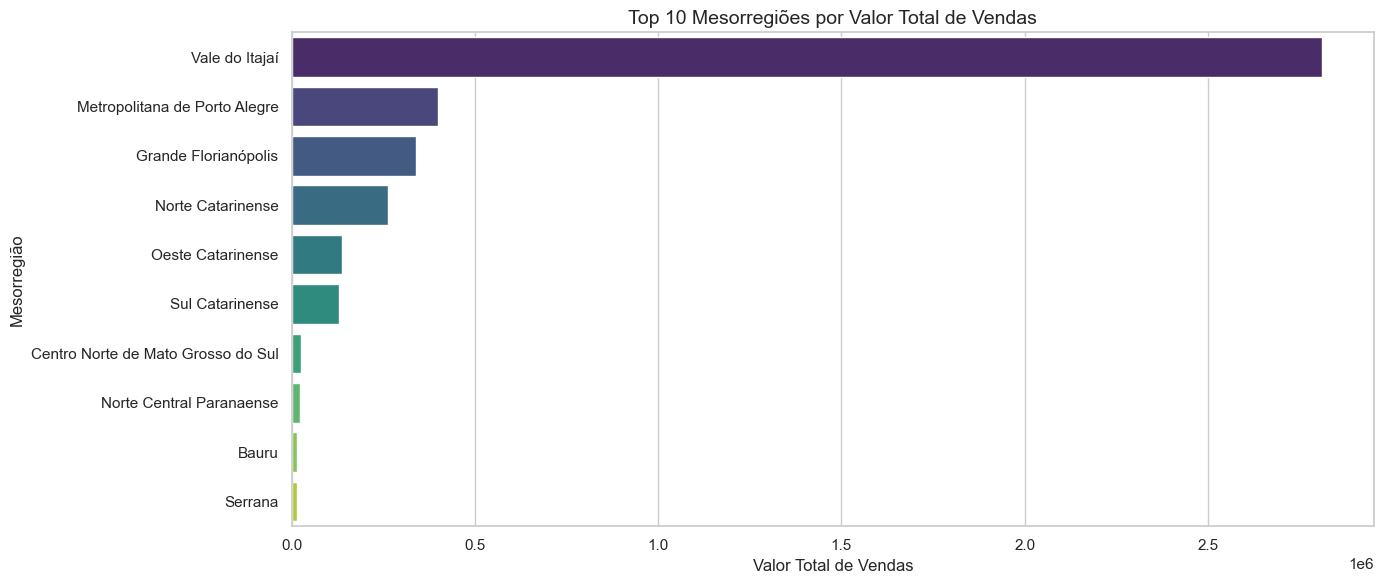


=== Matriz de vendas por UF e porte ===


porte,Grande,Media,Pequena
SG_UF,,,
AM,385.00,0.00,0.00
BA,0.00,896.00,0.00
CE,7632.00,0.00,0.00
DF,160.00,0.00,0.00
GO,0.00,263.40,0.00
MS,24934.00,0.00,0.00
PR,5512.99,30390.00,267.96
RS,395500.00,4485.00,0.00
SC,3647468.84,31059.64,17513.76


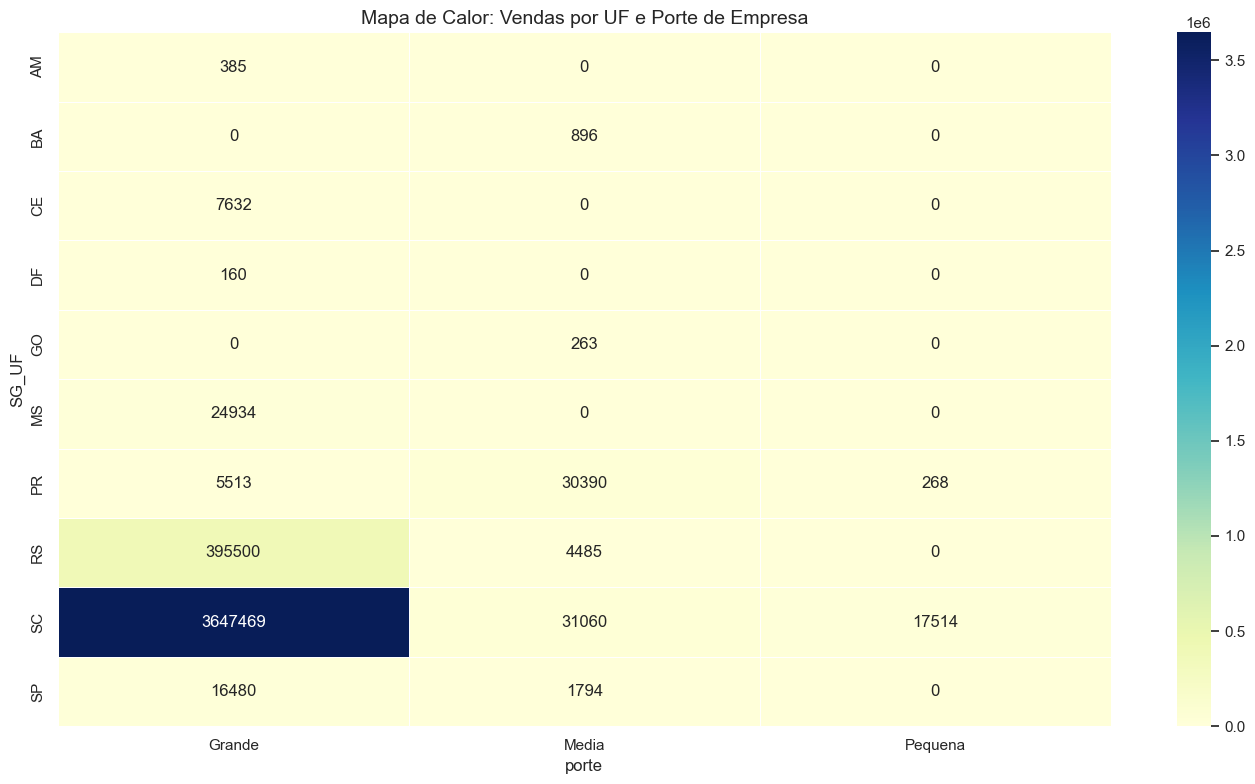


=== Ticket médio por porte de empresa ===


,porte,valor_total,valor_medio,num_vendas,ticket_medio
0,Grande,4098072.98,2898.212857,1414,2898.212857
1,Media,68888.04,269.093906,256,269.093906
2,Pequena,17781.72,123.484167,144,123.484167


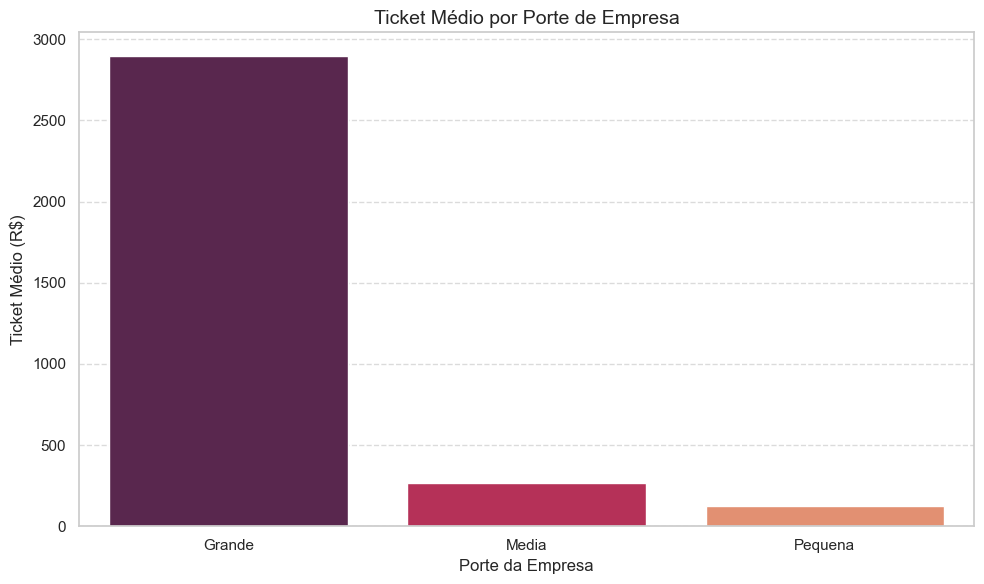


=== Análise combinada: Porte x UF x Tempo ===


ano                 2019       2020        2021       2022
trimestre              4          4           4          4
porte   SG_UF                                             
Grande  MS          0.00       0.00    24934.00       0.00
        PR        400.92     332.07        0.00    4780.00
        RS          0.00       0.00   395500.00       0.00
        SC     672700.51  439594.42  2148911.77  386262.14
        SP         40.15     600.00        0.00   15840.00
Media   PR       7350.00   23040.00        0.00       0.00
        RS          0.00       0.00        0.00    4485.00
        SC       5332.90    8090.46     8227.61    9408.67
        SP          0.00       0.00        0.00    1794.00
Pequena PR          0.00     141.00      126.96       0.00
        SC       2518.26    2853.33     3605.07    8537.10

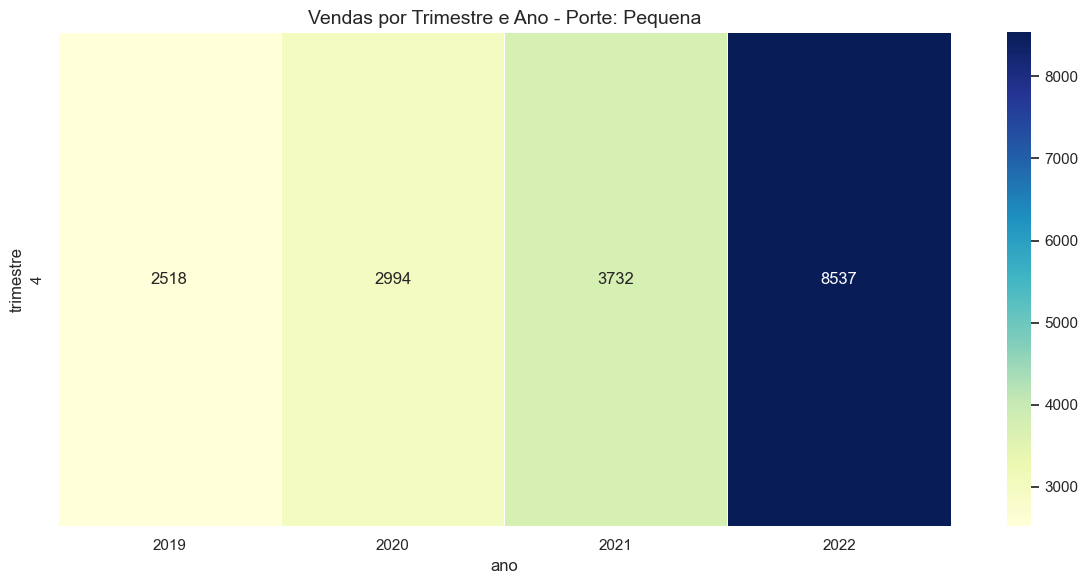

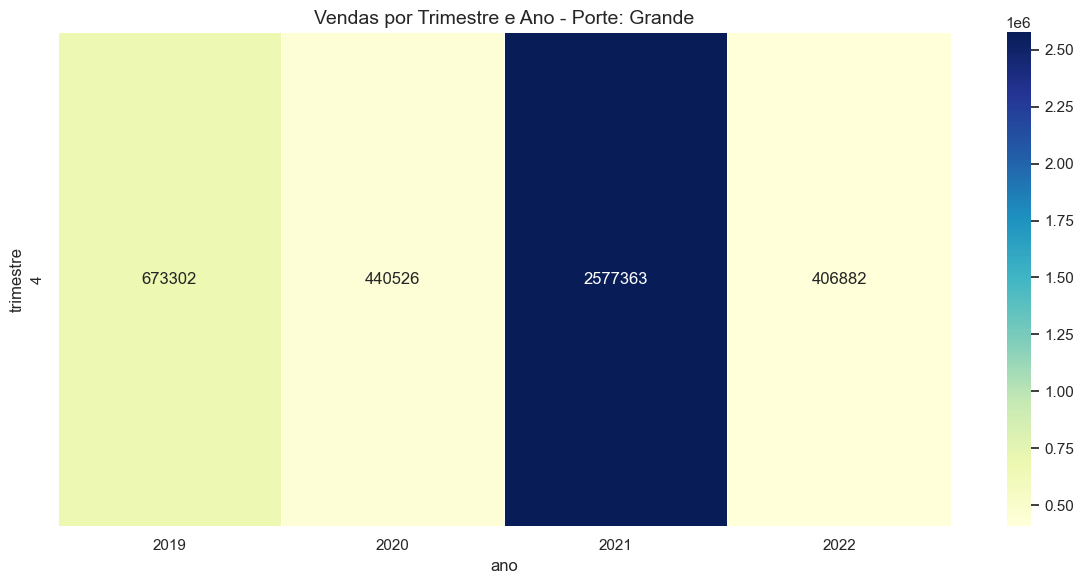

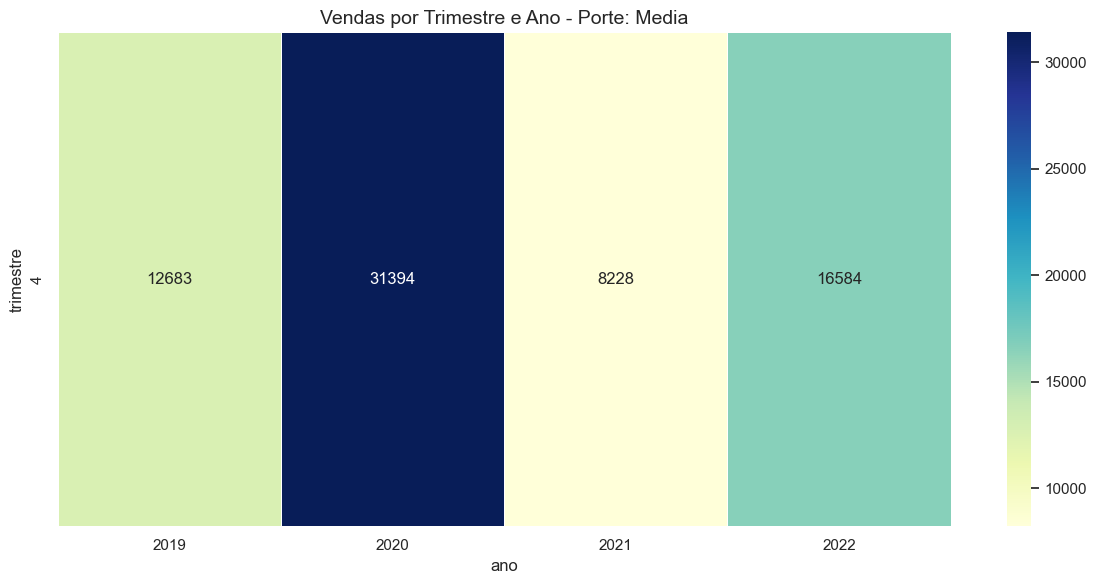

In [58]:
# 12.1 Agrupar por UF e somar o valor total
if "SG_UF" in df_merged.columns:
    vendas_por_uf = df_merged.groupby("SG_UF").agg({
        "valor": ["sum", "mean", "count"],
        "ID_cliente": pd.Series.nunique
    }).reset_index()
    
    vendas_por_uf.columns = ["SG_UF", "valor_total", "valor_medio", "num_vendas", "num_clientes"]
    vendas_por_uf["ticket_medio"] = vendas_por_uf["valor_total"] / vendas_por_uf["num_vendas"]
    vendas_por_uf = vendas_por_uf.sort_values("valor_total", ascending=False)
    
    print("=== Análise de vendas por UF ===")
    display(vendas_por_uf)
    
    # Visualizar número de clientes por UF
    plt.figure(figsize=(12, 6))
    sns.barplot(data=vendas_por_uf, x="SG_UF", y="num_clientes", palette="Blues_d")
    plt.title("Número de Clientes por UF", fontsize=14)
    plt.xlabel("UF")
    plt.ylabel("Número de Clientes Únicos")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 12.2 Agrupar por mesorregiões, se a coluna existir
if "NM_MESO" in df_merged.columns:
    # Agrupar por mesorregião
    vendas_por_meso = df_merged.groupby(["SG_UF", "NM_MESO"]).agg({
        "valor": ["sum", "mean", "count"],
        "ID_cliente": pd.Series.nunique
    }).reset_index()
    
    vendas_por_meso.columns = ["SG_UF", "NM_MESO", "valor_total", "valor_medio", "num_vendas", "num_clientes"]
    vendas_por_meso["ticket_medio"] = vendas_por_meso["valor_total"] / vendas_por_meso["num_vendas"]
    vendas_por_meso = vendas_por_meso.sort_values("valor_total", ascending=False)
    
    print("\n=== Top 15 mesorregiões por valor total de vendas ===")
    display(vendas_por_meso.head(15))
    
    # Visualizar top 10 mesorregiões
    plt.figure(figsize=(14, 6))
    top10_meso = vendas_por_meso.head(10)
    sns.barplot(data=top10_meso, x="valor_total", y="NM_MESO", palette="viridis")
    plt.title("Top 10 Mesorregiões por Valor Total de Vendas", fontsize=14)
    plt.xlabel("Valor Total de Vendas")
    plt.ylabel("Mesorregião")
    plt.tight_layout()
    plt.show()

# 12.3 Agrupar por porte, se a coluna existir
if "porte" in df_merged.columns:
    # Análise por porte e UF
    vendas_porte_uf = df_merged.groupby(["porte", "SG_UF"])["valor"].sum().reset_index()
    
    # Criar pivot table
    pivot_porte_uf = vendas_porte_uf.pivot(index="SG_UF", columns="porte", values="valor")
    pivot_porte_uf = pivot_porte_uf.fillna(0)  # Preencher NaN com zero
    
    print("\n=== Matriz de vendas por UF e porte ===")
    display(pivot_porte_uf)
    
    # Visualizar mapa de calor
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot_porte_uf, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=.5)
    plt.title("Mapa de Calor: Vendas por UF e Porte de Empresa", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Ticket médio por porte
    ticket_por_porte = df_merged.groupby("porte").agg({
        "valor": ["sum", "mean"],
        "ID_cliente": "count"
    }).reset_index()
    
    ticket_por_porte.columns = ["porte", "valor_total", "valor_medio", "num_vendas"]
    ticket_por_porte["ticket_medio"] = ticket_por_porte["valor_total"] / ticket_por_porte["num_vendas"]
    
    print("\n=== Ticket médio por porte de empresa ===")
    display(ticket_por_porte)
    
    # Visualizar ticket médio
    plt.figure(figsize=(10, 6))
    sns.barplot(data=ticket_por_porte, x="porte", y="ticket_medio", palette="rocket")
    plt.title("Ticket Médio por Porte de Empresa", fontsize=14)
    plt.xlabel("Porte da Empresa")
    plt.ylabel("Ticket Médio (R$)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 12.4 Análise combinada: Porte, Região e Tempo
if "porte" in df_merged.columns and "SG_UF" in df_merged.columns:
    # Agrupar por porte, UF e trimestre
    vendas_combinadas = df_merged.groupby(["porte", "SG_UF", "ano", "trimestre"])["valor"].sum().reset_index()
    
    # Selecionar UFs com maior volume para melhor visualização
    top_ufs = vendas_por_uf.head(5)["SG_UF"].tolist()
    vendas_filtradas = vendas_combinadas[vendas_combinadas["SG_UF"].isin(top_ufs)]
    
    # Criar pivot table
    pivot_combinado = vendas_filtradas.pivot_table(
        index=["porte", "SG_UF"],
        columns=["ano", "trimestre"],
        values="valor",
        aggfunc="sum"
    ).fillna(0)
    
    print("\n=== Análise combinada: Porte x UF x Tempo ===")
    display(pivot_combinado)
    
    # Análise de evolução específica por porte
    for porte_tipo in df_merged["porte"].unique():
        plt.figure(figsize=(12, 6))
        df_porte = df_merged[df_merged["porte"] == porte_tipo]
        
        # Agrupar por trimestre e ano
        vendas_porte_tempo = df_porte.groupby(["ano", "trimestre"])["valor"].sum().reset_index()
        
        # Criar pivot table para plotagem
        pivot_porte = vendas_porte_tempo.pivot(index="trimestre", columns="ano", values="valor")
        
        sns.heatmap(pivot_porte, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=.5)
        plt.title(f"Vendas por Trimestre e Ano - Porte: {porte_tipo}", fontsize=14)
        plt.tight_layout()
        plt.show()

# 13. Análise de Clientes e RFM

Nesta seção, realizamos uma análise aprofundada dos clientes utilizando a metodologia RFM (Recency, Frequency, Monetary):
1. Cálculo das métricas RFM para cada cliente
2. Segmentação dos clientes em grupos estratégicos
3. Análise de valor vitalício do cliente (LTV)
4. Visualização da distribuição dos clientes por segmento

Esta análise permite que a equipe de marketing desenvolva estratégias personalizadas para diferentes tipos de clientes, focando recursos nos segmentos mais valiosos.

Data de referência para análise RFM: 2022-12-31 00:00:00
Tabela RFM - primeiras linhas:


,Recency,Frequency,Monetary
ID_cliente,,,
00b356d161a7a65b3617a4536c282b463b25d88bf60d399a2e3cccc6ba08aa26,749,3,136.26
00b88c5a2bc5e5880a140c933487ad7f63b18b71ba4dd8a75918298fd1c33073,78,2,252.22
013f5f7bd8454a2f6774d182213b247e4c5ed34275bbe71a98de035d60c81718,750,4,553.98
01850840fa804366d4e118742cd74ee3efa38783c228cb7e75cce0e06ef4e644,751,1,150.00
02ac4607976557f300d1ecd36b679d568a760b60c043fbc7b348d2c4fe678a56,5,3,271.02



Estatísticas RFM:


,Recency,Frequency,Monetary
count,610.000000,610.000000,6.100000e+02
mean,568.665574,2.973770,6.860234e+03
std,413.288394,2.949933,8.445923e+04
min,0.000000,1.000000,3.990000e+00
25%,77.250000,1.000000,9.386250e+01
50%,443.000000,2.000000,2.467000e+02
75%,808.000000,4.000000,6.629125e+02
max,1178.000000,24.000000,1.966190e+06


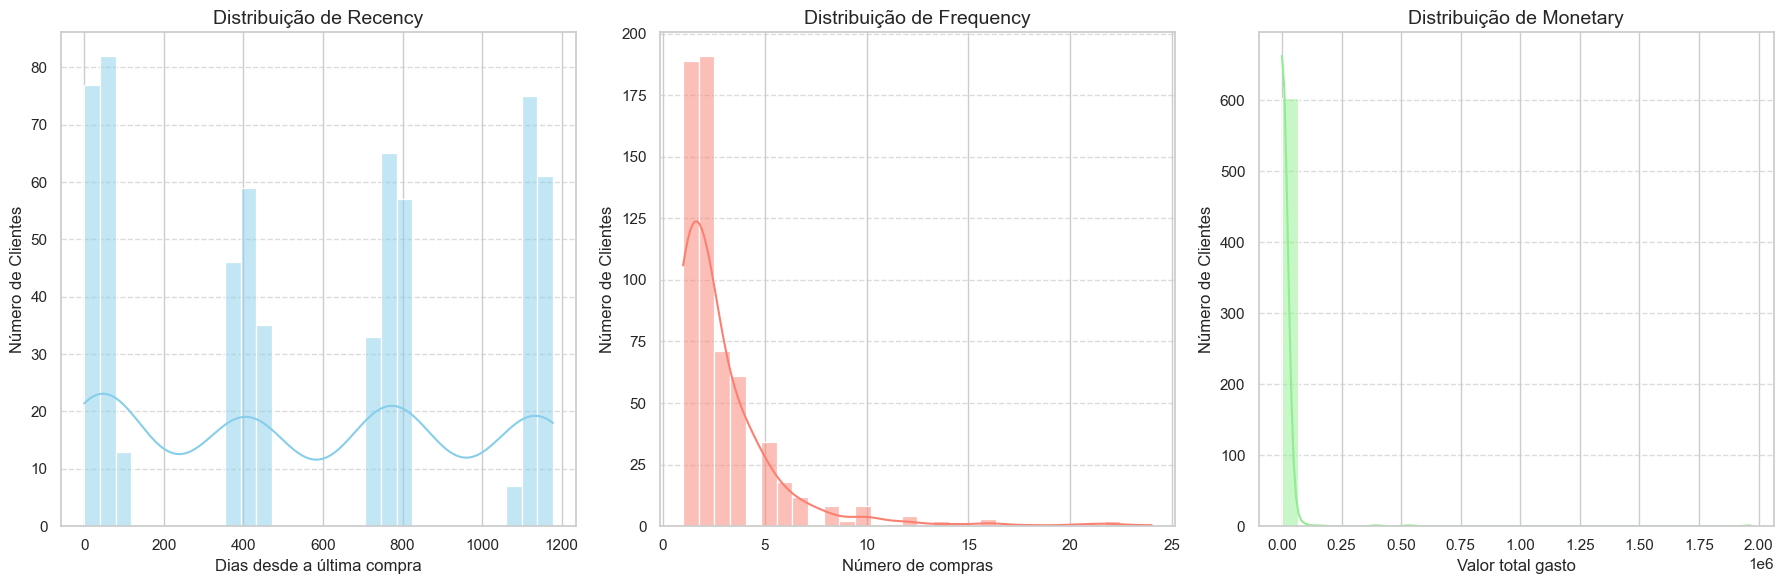

Aviso: Usando método alternativo para criar quartis devido a valores repetidos.

Distribuição de clientes por segmento:


Segmento
Hibernados             126
Clientes Recentes      122
Em Risco                90
Campeões                83
Clientes Potenciais     81
Não Podemos Perder      51
Precisam Atenção        36
Clientes Leais          21
Name: count, dtype: int64

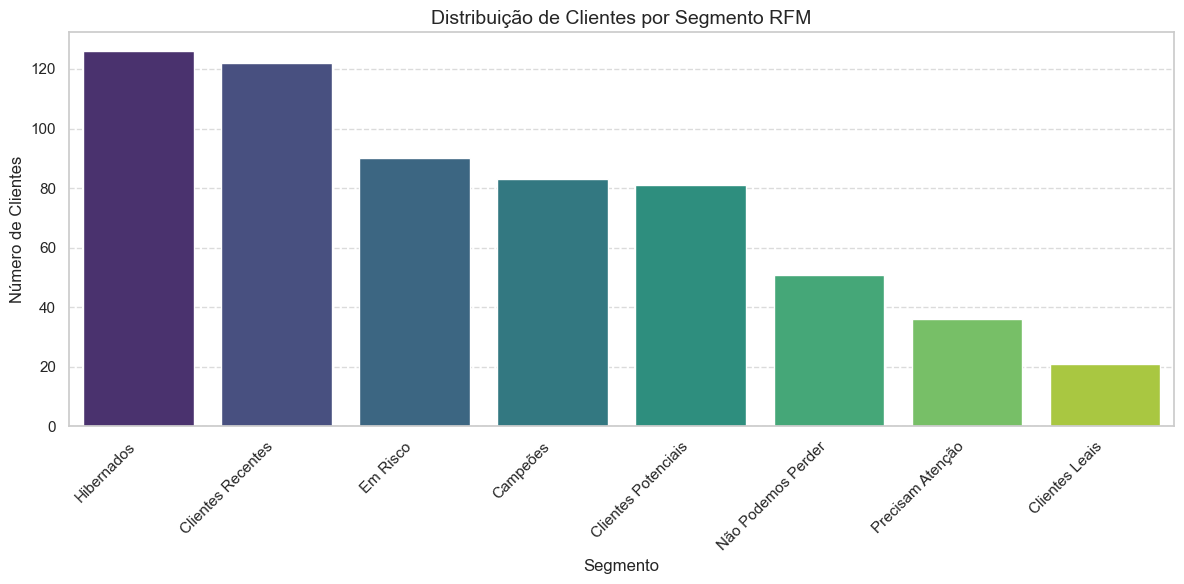


Estatísticas de Lifetime Value (LTV):
Taxa de retenção: 69.02%
LTV médio: R$ 21335.83


count    6.100000e+02
mean     2.133583e+04
std      2.725405e+05
min      4.565370e-01
25%      2.111256e+02
50%      5.986876e+02
75%      1.694606e+03
max      6.345903e+06
dtype: float64

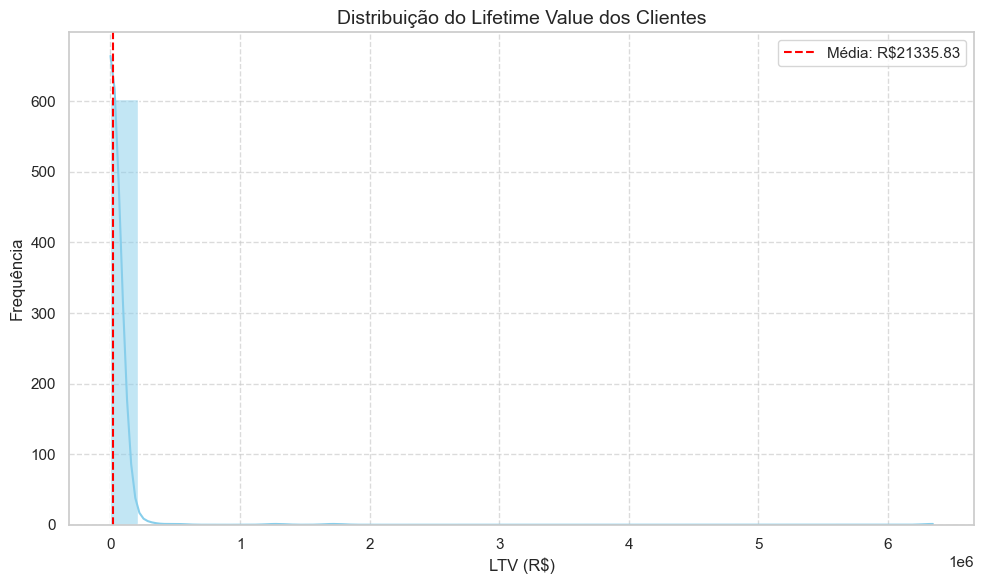


LTV Médio por Segmento:


Segmento
Campeões               101686.898844
Em Risco                30773.825695
Não Podemos Perder      13880.097719
Clientes Potenciais     12341.882360
Precisam Atenção          435.299192
Clientes Leais            346.605188
Hibernados                312.451137
Clientes Recentes         289.351455
Name: LTV, dtype: float64

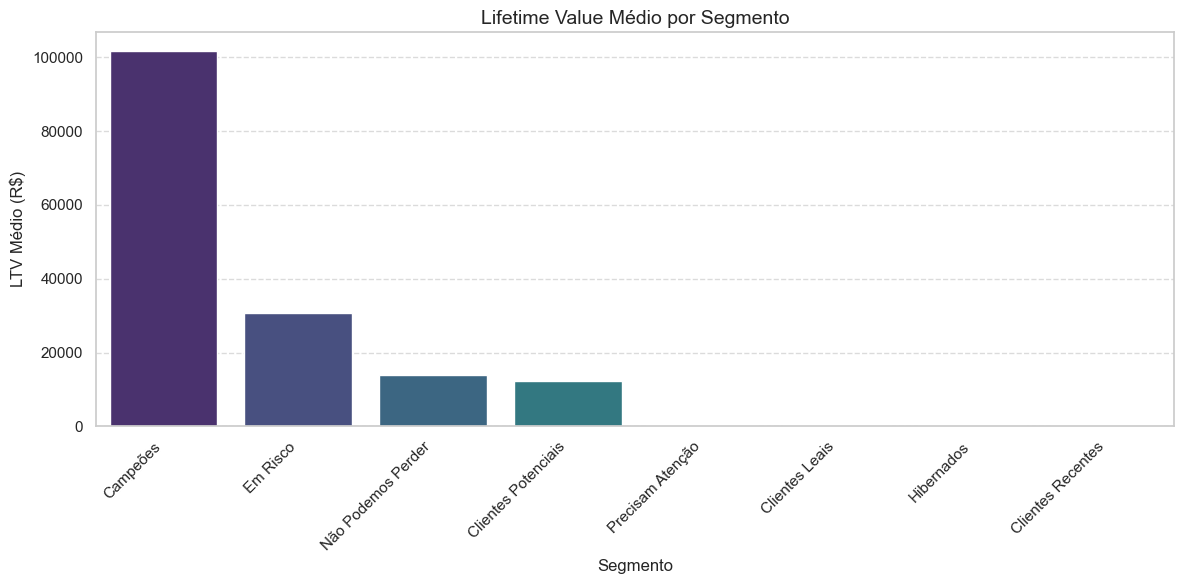

In [59]:
# 13.1 Análise de Retenção e Frequência (RFM)
# Converter a coluna "data" de df_vendas para datetime, se ainda não estiver
df_vendas["data"] = pd.to_datetime(df_vendas["data"], errors="coerce")

# Definir uma data de referência (por exemplo, a data máxima do dataset)
ref_date = df_vendas["data"].max()
print("Data de referência para análise RFM:", ref_date)

# Calcular RFM
rfm = df_vendas.groupby("ID_cliente").agg({
    "data": lambda x: (ref_date - x.max()).days,  # Recency
    "ID_cliente": "count",                        # Frequency
    "valor": "sum"                                # Monetary
}).rename(columns={"data": "Recency", "ID_cliente": "Frequency", "valor": "Monetary"})

print("Tabela RFM - primeiras linhas:")
display(rfm.head())

# Estatísticas da tabela RFM
print("\nEstatísticas RFM:")
display(rfm.describe())

# Plotar distribuições das métricas RFM
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.histplot(rfm["Recency"], kde=True, bins=30, color="skyblue")
plt.title("Distribuição de Recency", fontsize=14)
plt.xlabel("Dias desde a última compra")
plt.ylabel("Número de Clientes")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 2)
sns.histplot(rfm["Frequency"], kde=True, bins=30, color="salmon")
plt.title("Distribuição de Frequency", fontsize=14)
plt.xlabel("Número de compras")
plt.ylabel("Número de Clientes")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 3, 3)
sns.histplot(rfm["Monetary"], kde=True, bins=30, color="lightgreen")
plt.title("Distribuição de Monetary", fontsize=14)
plt.xlabel("Valor total gasto")
plt.ylabel("Número de Clientes")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 13.2 Segmentação de Clientes com base em RFM
try:
    # Criar quartis para cada métrica RFM
    # Nota: Recency é invertida (valores menores são melhores)
    rfm['R_quartil'] = pd.qcut(rfm['Recency'], 4, labels=range(4, 0, -1))
    rfm['F_quartil'] = pd.qcut(rfm['Frequency'], 4, labels=range(1, 5))
    rfm['M_quartil'] = pd.qcut(rfm['Monetary'], 4, labels=range(1, 5))
except ValueError:
    # Se houver muitos valores repetidos, pode ocorrer erro no qcut
    # Solução: usar quantile para criar bins manualmente
    print("Aviso: Usando método alternativo para criar quartis devido a valores repetidos.")
    r_bins = [0, rfm['Recency'].quantile(0.25), rfm['Recency'].quantile(0.5), 
              rfm['Recency'].quantile(0.75), rfm['Recency'].max()]
    f_bins = [0, rfm['Frequency'].quantile(0.25), rfm['Frequency'].quantile(0.5), 
              rfm['Frequency'].quantile(0.75), rfm['Frequency'].max()]
    m_bins = [0, rfm['Monetary'].quantile(0.25), rfm['Monetary'].quantile(0.5), 
              rfm['Monetary'].quantile(0.75), rfm['Monetary'].max()]
    
    rfm['R_quartil'] = pd.cut(rfm['Recency'], bins=r_bins, labels=range(4, 0, -1), include_lowest=True)
    rfm['F_quartil'] = pd.cut(rfm['Frequency'], bins=f_bins, labels=range(1, 5), include_lowest=True)
    rfm['M_quartil'] = pd.cut(rfm['Monetary'], bins=m_bins, labels=range(1, 5), include_lowest=True)

# Criar score RFM
rfm['RFM_Score'] = rfm['R_quartil'].astype(str) + rfm['F_quartil'].astype(str) + rfm['M_quartil'].astype(str)

# Segmentar clientes
def segmentar_cliente(row):
    if row['R_quartil'] in [3, 4] and row['F_quartil'] in [3, 4] and row['M_quartil'] in [3, 4]:
        return 'Campeões'
    elif row['R_quartil'] in [3, 4] and row['F_quartil'] in [1, 2] and row['M_quartil'] in [3, 4]:
        return 'Clientes Potenciais'
    elif row['R_quartil'] in [3, 4] and row['F_quartil'] in [3, 4] and row['M_quartil'] in [1, 2]:
        return 'Clientes Leais'
    elif row['R_quartil'] in [3, 4] and row['F_quartil'] in [1, 2] and row['M_quartil'] in [1, 2]:
        return 'Clientes Recentes'
    elif row['R_quartil'] in [1, 2] and row['F_quartil'] in [3, 4] and row['M_quartil'] in [3, 4]:
        return 'Em Risco'
    elif row['R_quartil'] in [1, 2] and row['F_quartil'] in [1, 2] and row['M_quartil'] in [3, 4]:
        return 'Não Podemos Perder'
    elif row['R_quartil'] in [1, 2] and row['F_quartil'] in [3, 4] and row['M_quartil'] in [1, 2]:
        return 'Precisam Atenção'
    elif row['R_quartil'] in [1, 2] and row['F_quartil'] in [1, 2] and row['M_quartil'] in [1, 2]:
        return 'Hibernados'
    else:
        return 'Outros'

rfm['Segmento'] = rfm.apply(segmentar_cliente, axis=1)

# Visualizar a distribuição dos segmentos
print("\nDistribuição de clientes por segmento:")
segment_counts = rfm['Segmento'].value_counts()
display(segment_counts)

plt.figure(figsize=(12, 6))
segment_counts = rfm['Segmento'].value_counts()
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Distribuição de Clientes por Segmento RFM', fontsize=14)
plt.xlabel('Segmento')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 13.3 Calcular Lifetime Value (LTV) dos clientes

# Calcular valor médio por transação
avg_order_value = df_vendas.groupby('ID_cliente')['valor'].mean()

# Calcular frequência de compra (número de dias entre compras)
try:
    purchase_frequency = df_vendas.groupby('ID_cliente')['data'].agg(['min', 'max', 'count'])
    purchase_frequency['days_between'] = (purchase_frequency['max'] - purchase_frequency['min']).dt.days
    # Evitar divisão por zero
    purchase_frequency['days_between'] = purchase_frequency['days_between'].replace(0, 1)
    purchase_frequency['frequency'] = purchase_frequency['count'] / purchase_frequency['days_between']
    
    # Calcular taxa de retenção de clientes
    total_clientes = df_vendas['ID_cliente'].nunique()
    clientes_recorrentes = df_vendas.groupby('ID_cliente').size()
    clientes_recorrentes = clientes_recorrentes[clientes_recorrentes > 1].count()
    taxa_retencao = clientes_recorrentes / total_clientes if total_clientes > 0 else 0
    
    # Calcular Customer Value
    customer_value = avg_order_value * purchase_frequency['frequency']
    
    # Calcular LTV (Customer Value / (1 - Taxa de Retenção))
    # Evitar divisão por 1 (quando a taxa de retenção é 1)
    taxa_retencao_ajustada = min(taxa_retencao, 0.99)
    customer_ltv = customer_value / (1 - taxa_retencao_ajustada)
    
    # Mostrar estatísticas do LTV
    print("\nEstatísticas de Lifetime Value (LTV):")
    print(f"Taxa de retenção: {taxa_retencao:.2%}")
    print(f"LTV médio: R$ {customer_ltv.mean():.2f}")
    display(customer_ltv.describe())
    
    # Plotar distribuição do LTV
    plt.figure(figsize=(10, 6))
    sns.histplot(customer_ltv, bins=30, kde=True, color='skyblue')
    plt.title('Distribuição do Lifetime Value dos Clientes', fontsize=14)
    plt.xlabel('LTV (R$)')
    plt.ylabel('Frequência')
    plt.axvline(customer_ltv.mean(), color='red', linestyle='--', 
               label=f'Média: R${customer_ltv.mean():.2f}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 13.4 Análise de clientes por segmento RFM e LTV
    # Adicionar LTV à tabela RFM
    rfm['LTV'] = customer_ltv
    
    # Calcular LTV médio por segmento
    ltv_by_segment = rfm.groupby('Segmento')['LTV'].mean().sort_values(ascending=False)
    
    print("\nLTV Médio por Segmento:")
    display(ltv_by_segment)
    
    # Visualizar LTV por segmento
    plt.figure(figsize=(12, 6))
    sns.barplot(x=ltv_by_segment.index, y=ltv_by_segment.values, palette='viridis')
    plt.title('Lifetime Value Médio por Segmento', fontsize=14)
    plt.xlabel('Segmento')
    plt.ylabel('LTV Médio (R$)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Erro ao calcular LTV: {e}")
    print("Isso pode ocorrer quando há problemas com os dados de data ou quando há poucos clientes recorrentes.")

# 14. Visualização Geográfica Avançada

Nesta seção, criamos visualizações geográficas mais avançadas utilizando as coordenadas (latitude/longitude):
1. Mapa de calor regional (choropleth) para análise de vendas por estado
2. Mapa de pontos representando o volume de vendas por município
3. Análise de densidade geográfica de clientes
4. Visualização da penetração de mercado por região

Essas visualizações permitem identificar concentrações geográficas, oportunidades de expansão e áreas com potencial inexplorado.

Não foi possível mostrar o mapa interativo. Erro: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Alternativa: criando um mapa estático...


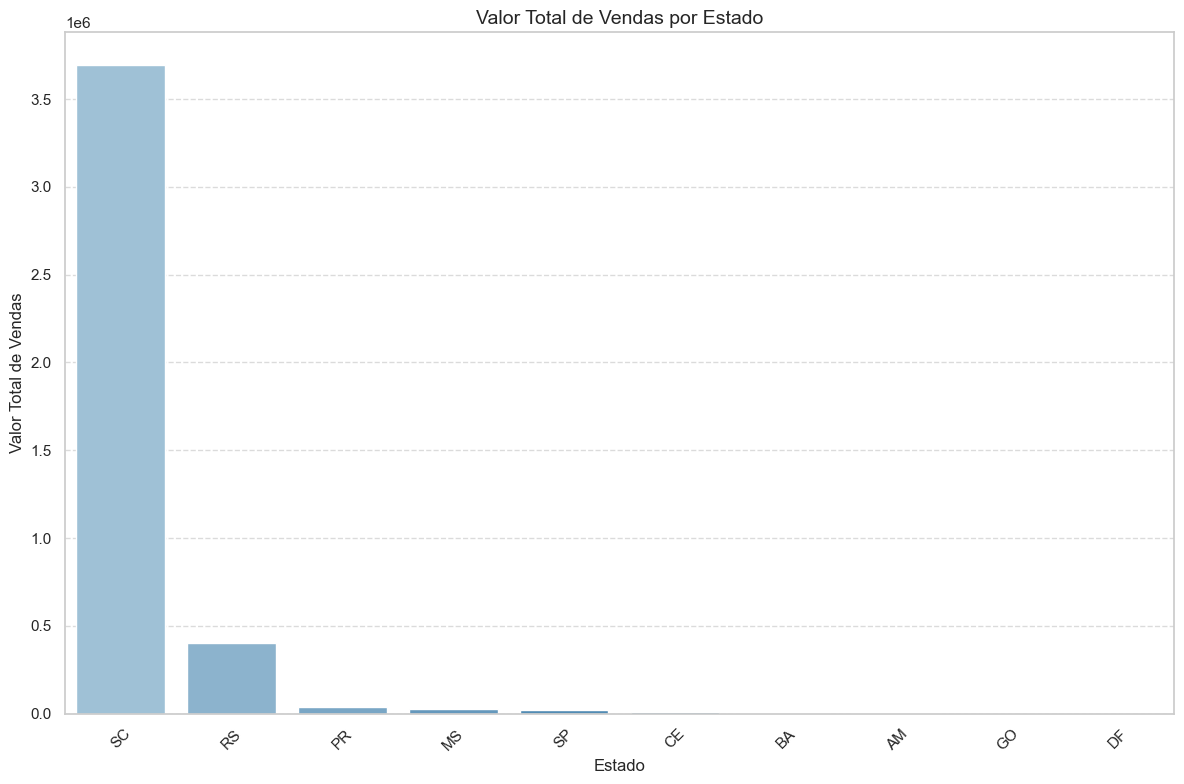

Não foi possível mostrar o mapa interativo de municípios. Erro: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Alternativa: mostrando top municípios...


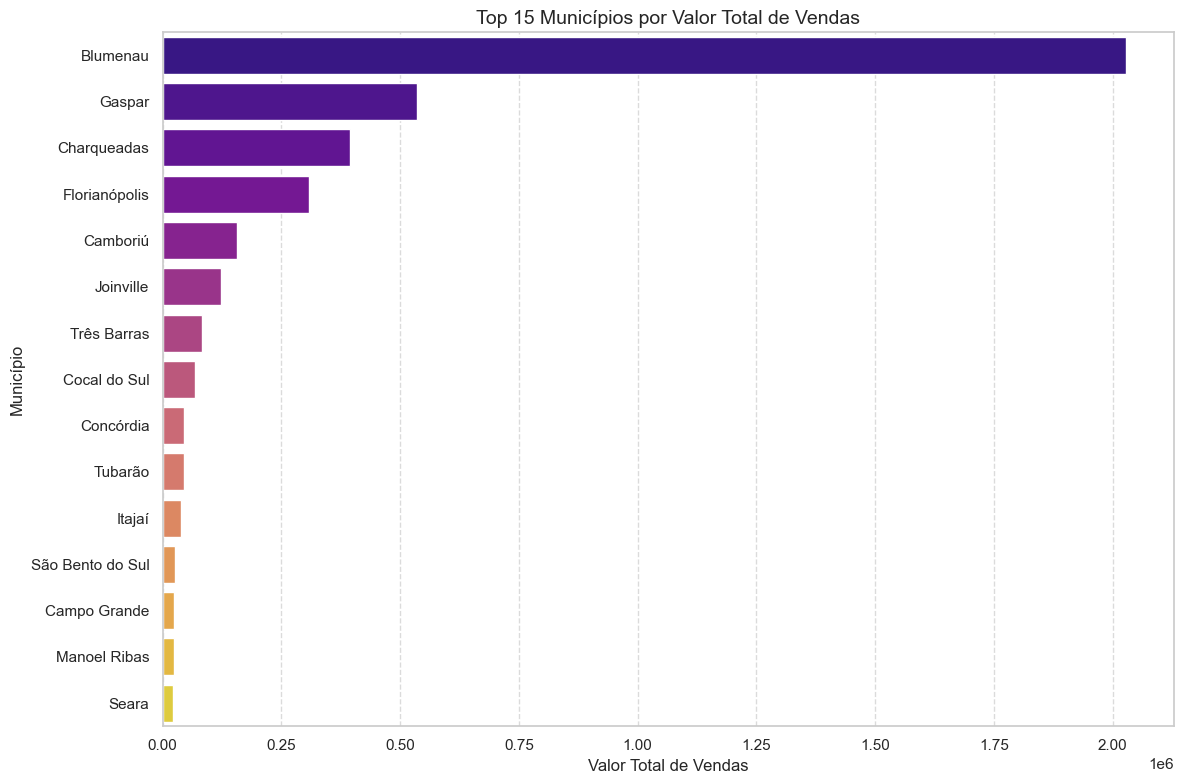

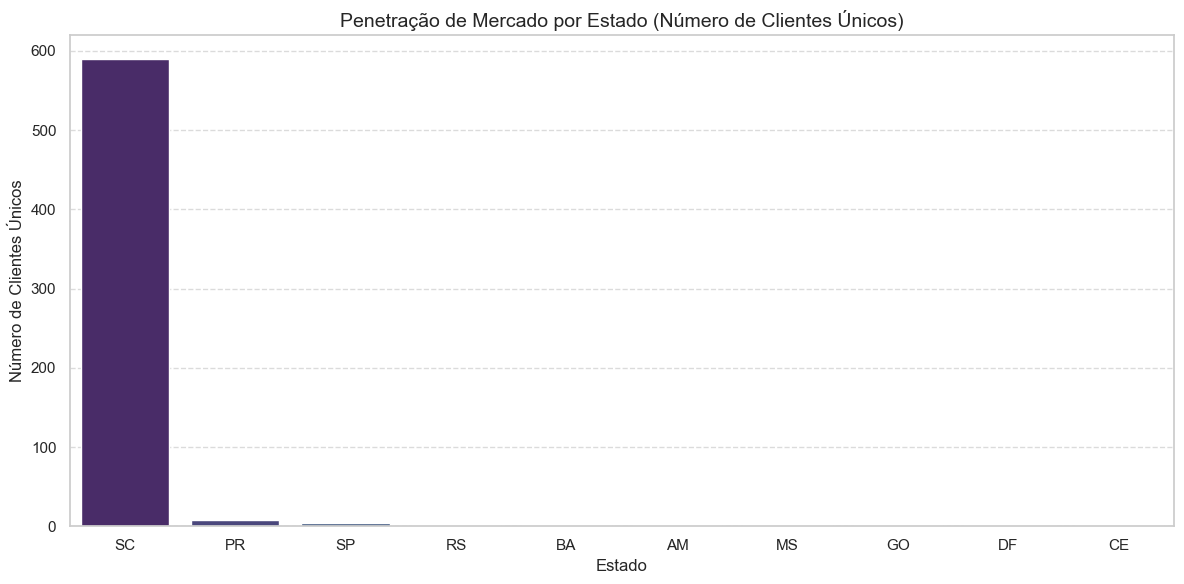

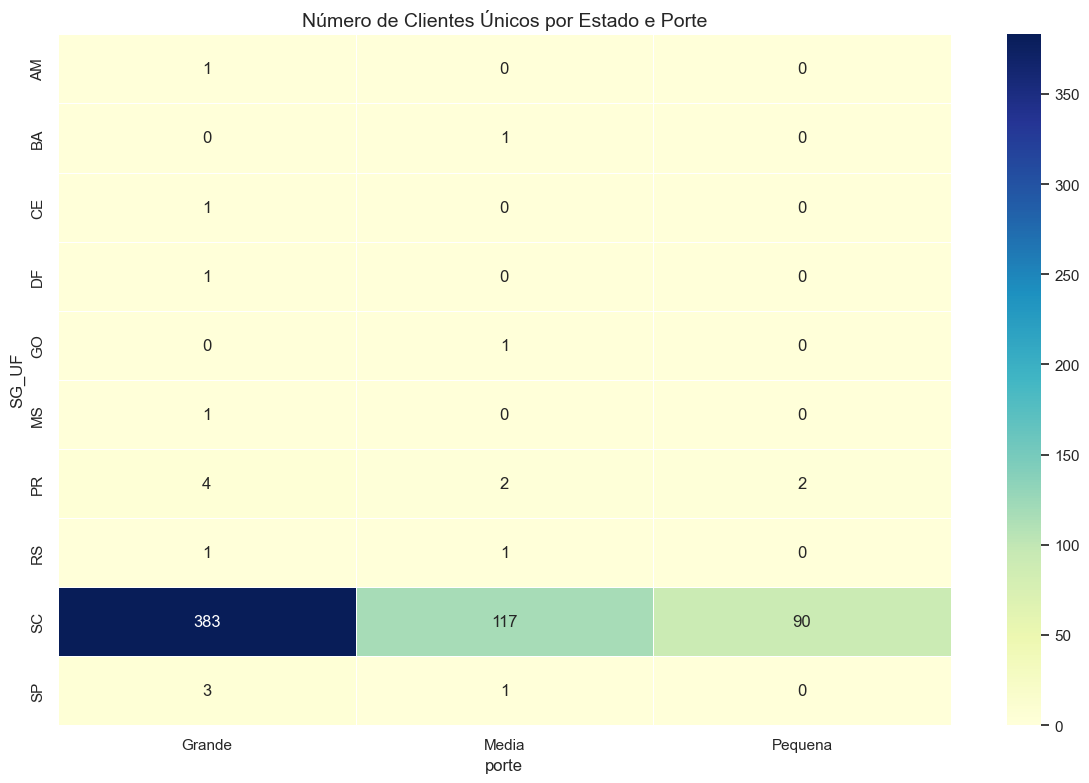

In [62]:
# 14.1 Mapa de Calor Regional (Choropleth)
try:
    # Agrupar dados por UF para o mapa
    df_uf = df_merged.groupby("SG_UF", as_index=False)[["valor", "ID_cliente"]].agg({
        "valor": "sum",
        "ID_cliente": pd.Series.nunique
    })
    df_uf.rename(columns={"valor": "valor_total", "ID_cliente": "num_clientes"}, inplace=True)
    
    # Tenta usar Plotly Express para criar o mapa de calor
    import plotly.express as px
    
    # Verificar se temos dados de UF
    if len(df_uf) > 0:
        # Criar figura com plotly express
        fig = px.choropleth_mapbox(
            df_uf,
            geojson="https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson",
            locations="SG_UF",
            featureidkey="properties.sigla",
            color="valor_total",
            color_continuous_scale="Blues",
            mapbox_style="carto-positron",
            zoom=3,
            center={"lat": -15.8, "lon": -47.9},
            opacity=0.7,
            labels={"valor_total": "Valor Total de Vendas"},
            title="Mapa de Calor: Vendas por Estado"
        )
        
        fig.update_layout(
            autosize=True,
            height=600,
            margin={"r": 0, "t": 40, "l": 0, "b": 0}
        )
        
        # Tenta mostrar a figura
        try:
            fig.show()
        except Exception as e:
            print(f"Não foi possível mostrar o mapa interativo. Erro: {e}")
            print("Alternativa: criando um mapa estático...")
            
            # Alternativa: criar um mapa estático com matplotlib
            plt.figure(figsize=(12, 8))
            sns.barplot(data=df_uf.sort_values("valor_total", ascending=False), 
                         x="SG_UF", y="valor_total", palette="Blues_d")
            plt.title("Valor Total de Vendas por Estado", fontsize=14)
            plt.xlabel("Estado")
            plt.ylabel("Valor Total de Vendas")
            plt.xticks(rotation=45)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
    else:
        print("Não há dados suficientes para criar o mapa de calor por UF.")
        
except ImportError:
    print("Biblioteca Plotly não está disponível. Criando visualização alternativa...")
    
    # Alternativa: criar um gráfico de barras com matplotlib
    plt.figure(figsize=(12, 8))
    df_uf_sorted = df_uf.sort_values("valor_total", ascending=False)
    sns.barplot(data=df_uf_sorted, x="SG_UF", y="valor_total", palette="Blues_d")
    plt.title("Valor Total de Vendas por Estado", fontsize=14)
    plt.xlabel("Estado")
    plt.ylabel("Valor Total de Vendas")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Erro ao criar mapa de calor: {e}")

# 14.2 Mapa de Pontos por Município
try:
    # Verificar se temos coordenadas geográficas
    if 'LAT' in df_merged.columns and 'LONG' in df_merged.columns:
        # Agrupar dados por município
        df_municipios = df_merged.groupby(['codigo_municipio', 'NM_MUN', 'LAT', 'LONG'], as_index=False).agg({
            'valor': 'sum',
            'ID_cliente': pd.Series.nunique
        })
        df_municipios.rename(columns={'valor': 'valor_total', 'ID_cliente': 'num_clientes'}, inplace=True)
        
        # Calcular tamanho da bolha para visualização (logarítmico para evitar bolhas muito grandes)
        df_municipios['tamanho_bolha'] = np.log1p(df_municipios['valor_total']) * 2
        
        # Criar o mapa com Plotly Express
        fig = px.scatter_mapbox(
            df_municipios,
            lat='LAT',
            lon='LONG',
            size='tamanho_bolha',
            color='valor_total',
            hover_name='NM_MUN',
            hover_data={
                'LAT': False,
                'LONG': False,
                'tamanho_bolha': False,
                'valor_total': True,
                'num_clientes': True
            },
            color_continuous_scale=px.colors.sequential.Plasma,
            title='Distribuição Geográfica das Vendas por Município',
            size_max=25,
            zoom=3.5,
            mapbox_style="carto-positron"
        )
        
        fig.update_layout(
            autosize=True,
            height=600,
            margin={"r": 0, "t": 40, "l": 0, "b": 0}
        )
        
        # Tenta mostrar a figura
        try:
            fig.show()
        except Exception as e:
            print(f"Não foi possível mostrar o mapa interativo de municípios. Erro: {e}")
            print("Alternativa: mostrando top municípios...")
            
            # Alternativa: mostrar top 15 municípios em gráfico de barras
            plt.figure(figsize=(12, 8))
            top15_municipios = df_municipios.sort_values('valor_total', ascending=False).head(15)
            sns.barplot(data=top15_municipios, x='valor_total', y='NM_MUN', palette='plasma')
            plt.title('Top 15 Municípios por Valor Total de Vendas', fontsize=14)
            plt.xlabel('Valor Total de Vendas')
            plt.ylabel('Município')
            plt.grid(axis='x', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
    else:
        print("Dados de latitude e longitude não estão disponíveis para criar o mapa de pontos.")
        
except ImportError:
    print("Biblioteca Plotly não está disponível. Criando visualização alternativa...")
    
    # Alternativa: mostrar top 15 municípios em gráfico de barras
    plt.figure(figsize=(12, 8))
    df_mun_vendas = df_merged.groupby(['NM_MUN'])['valor'].sum().reset_index()
    top15_municipios = df_mun_vendas.sort_values('valor', ascending=False).head(15)
    sns.barplot(data=top15_municipios, x='valor', y='NM_MUN', palette='plasma')
    plt.title('Top 15 Municípios por Valor Total de Vendas', fontsize=14)
    plt.xlabel('Valor Total de Vendas')
    plt.ylabel('Município')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Erro ao criar mapa de pontos: {e}")

# 14.3 Análise de Penetração de Mercado por Região
# Agrupar por UF e calcular métricas de penetração
if 'SG_UF' in df_merged.columns:
    # Cálculo simplificado de penetração (clientes únicos por UF)
    penetracao_uf = df_merged.groupby('SG_UF')['ID_cliente'].nunique().reset_index()
    penetracao_uf.columns = ['SG_UF', 'num_clientes']
    
    # Ordenar por número de clientes
    penetracao_uf = penetracao_uf.sort_values('num_clientes', ascending=False)
    
    # Criar visualização
    plt.figure(figsize=(12, 6))
    sns.barplot(data=penetracao_uf, x='SG_UF', y='num_clientes', palette='viridis')
    plt.title('Penetração de Mercado por Estado (Número de Clientes Únicos)', fontsize=14)
    plt.xlabel('Estado')
    plt.ylabel('Número de Clientes Únicos')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Calcular densidade de clientes por UF (se tivermos o total de empresas potenciais)
    if 'porte' in df_merged.columns:
        # Distribuição de clientes por porte dentro das UFs
        clientes_porte_uf = df_merged.groupby(['SG_UF', 'porte'])['ID_cliente'].nunique().reset_index()
        pivot_clientes = clientes_porte_uf.pivot(index='SG_UF', columns='porte', values='ID_cliente').fillna(0)
        
        # Criar mapa de calor
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_clientes, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=.5)
        plt.title('Número de Clientes Únicos por Estado e Porte', fontsize=14)
        plt.tight_layout()
        plt.show()

# 15. Análise de Produtos e Cesta de Compras

Nesta seção, realizamos uma análise detalhada dos produtos e padrões de compra:
1. Identificação dos produtos mais vendidos e sua distribuição 
2. Análise de produtos frequentemente comprados juntos (análise de cesta)
3. Segmentação de produtos por sazonalidade e tendência
4. Análise de elasticidade de preço para produtos selecionados

Estas análises ajudam a equipe de marketing a desenvolver estratégias de cross-selling, up-selling e promoções direcionadas.


=== Top 15 produtos por frequência de vendas ===


,produto,frequencia,valor_total,valor_medio
0,produto_00,1344,306684.64,228.187976
1,produto_01,70,35146.18,502.088286
2,produto_03,63,37820.13,600.319524
3,produto_02,58,9949.25,171.538793
4,produto_06,47,4737.21,100.791702
5,produto_04,31,2588946.07,83514.389355
6,produto_12,23,55310.00,2404.782609
7,produto_11,20,49081.80,2454.090000
8,produto_05,18,3485.58,193.643333
9,produto_17,16,125742.10,7858.881250



=== Top 15 produtos por valor total de vendas ===


,produto,frequencia,valor_total,valor_medio
5,produto_04,31,2588946.07,83514.389355
10,produto_35,14,395500.00,28250.000000
0,produto_00,1344,306684.64,228.187976
24,produto_28,3,177321.45,59107.150000
31,produto_53,1,155800.00,155800.000000
9,produto_17,16,125742.10,7858.881250
18,produto_18,7,68272.90,9753.271429
6,produto_12,23,55310.00,2404.782609
7,produto_11,20,49081.80,2454.090000
2,produto_03,63,37820.13,600.319524


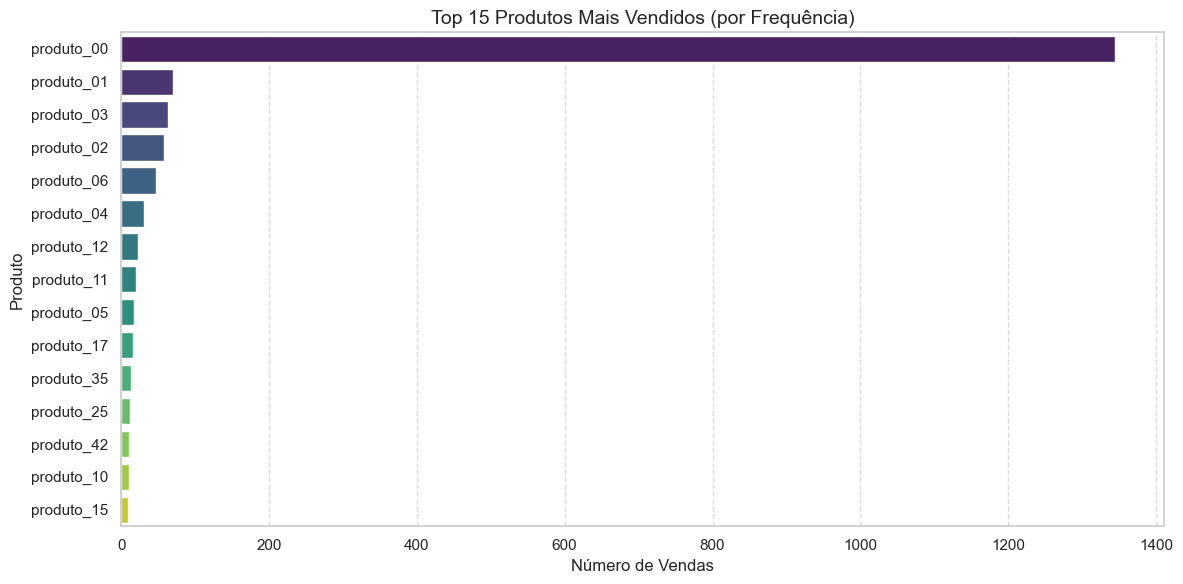

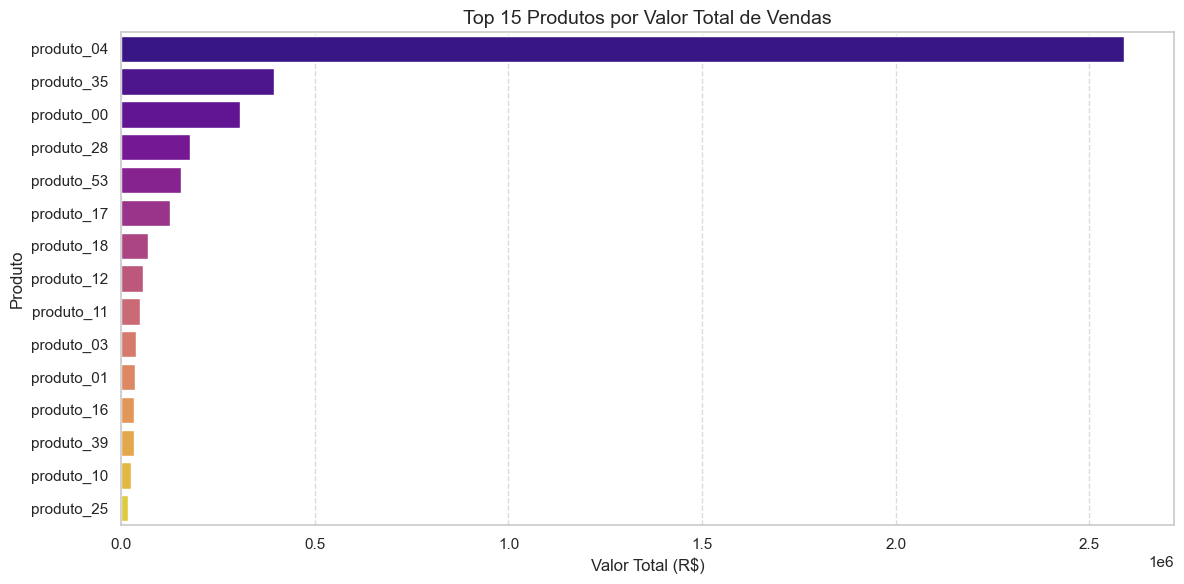


7 clientes compraram múltiplos produtos (potencial para cross-selling)
Não foi possível encontrar regras de associação com os critérios atuais.


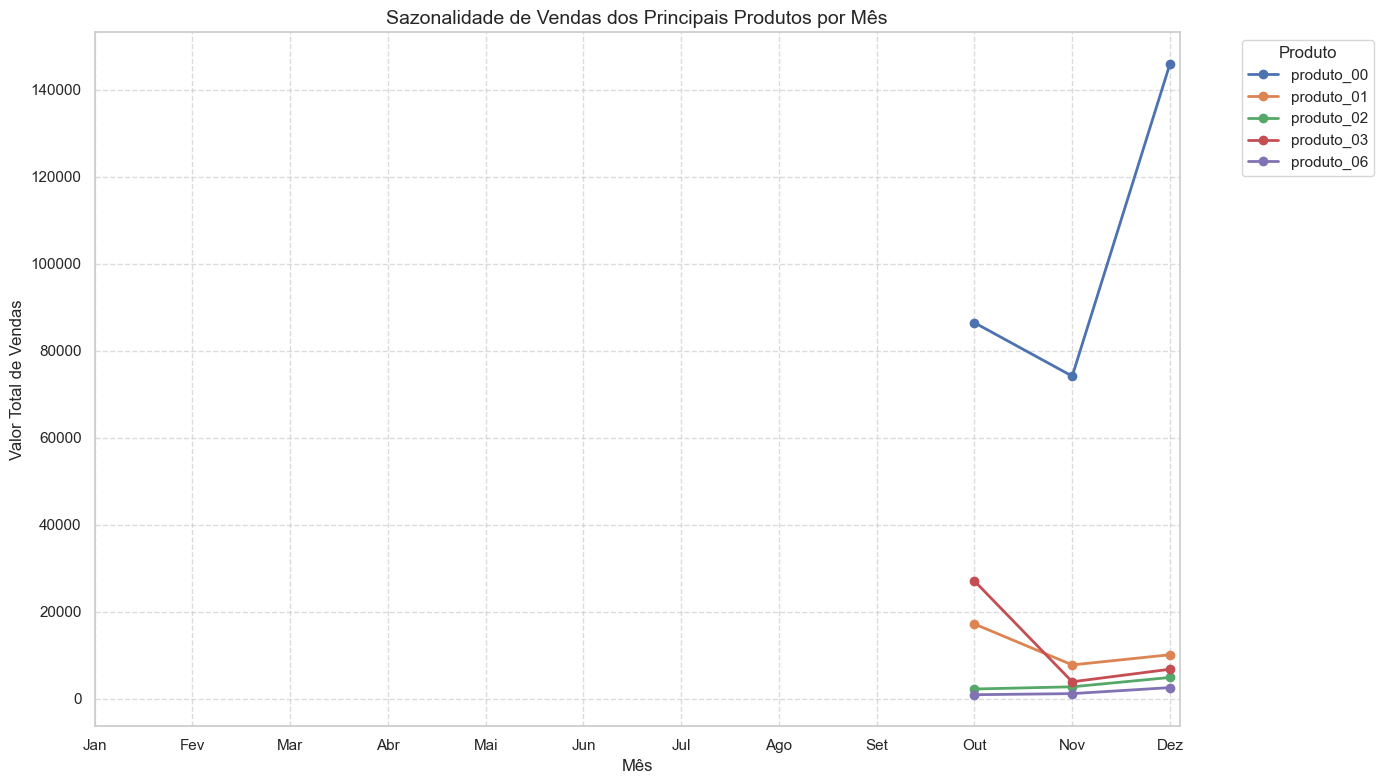

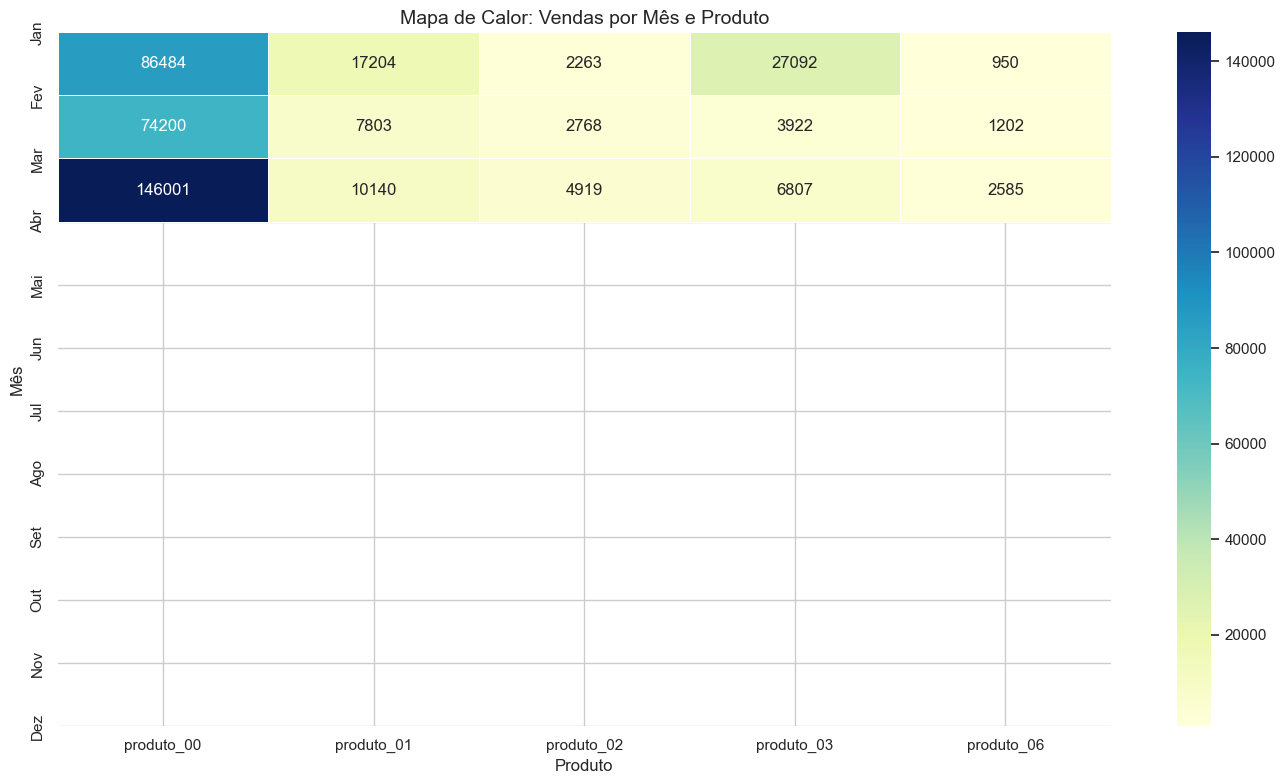

In [63]:
# 15.1 Análise de produtos mais vendidos
if 'produto' in df_merged.columns:
    # Análise de frequência de produtos
    freq_produtos = df_merged['produto'].value_counts().reset_index()
    freq_produtos.columns = ['produto', 'frequencia']
    
    # Calcular valor total por produto
    valor_produtos = df_merged.groupby('produto')['valor'].sum().reset_index()
    valor_produtos.columns = ['produto', 'valor_total']
    
    # Unir as informações
    analise_produtos = pd.merge(freq_produtos, valor_produtos, on='produto')
    analise_produtos['valor_medio'] = analise_produtos['valor_total'] / analise_produtos['frequencia']
    
    # Ordenar por frequência
    top_produtos_freq = analise_produtos.sort_values('frequencia', ascending=False).head(15)
    
    # Ordenar por valor total
    top_produtos_valor = analise_produtos.sort_values('valor_total', ascending=False).head(15)
    
    print("=== Top 15 produtos por frequência de vendas ===")
    display(top_produtos_freq)
    
    print("\n=== Top 15 produtos por valor total de vendas ===")
    display(top_produtos_valor)
    
    # Visualizar top produtos por frequência
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_produtos_freq, x='frequencia', y='produto', palette='viridis')
    plt.title('Top 15 Produtos Mais Vendidos (por Frequência)', fontsize=14)
    plt.xlabel('Número de Vendas')
    plt.ylabel('Produto')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Visualizar top produtos por valor
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_produtos_valor, x='valor_total', y='produto', palette='plasma')
    plt.title('Top 15 Produtos por Valor Total de Vendas', fontsize=14)
    plt.xlabel('Valor Total (R$)')
    plt.ylabel('Produto')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # 15.2 Análise de correlação entre produtos (cesta de compras)
    try:
        from mlxtend.frequent_patterns import apriori, association_rules
        
        # Verificar se temos múltiplos produtos comprados pelos clientes
        clientes_multiplos_produtos = df_merged.groupby('ID_cliente')['produto'].nunique()
        clientes_cross_selling = clientes_multiplos_produtos[clientes_multiplos_produtos > 1].count()
        
        if clientes_cross_selling > 0:
            print(f"\n{clientes_cross_selling} clientes compraram múltiplos produtos (potencial para cross-selling)")
            
            # Criar matriz de compras produto x cliente (1 se comprou, 0 se não comprou)
            basket = pd.crosstab(df_merged['ID_cliente'], df_merged['produto'])
            
            # Converter para binário (1 para compra, 0 para não-compra)
            basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)
            
            # Aplicar algoritmo Apriori para encontrar conjuntos frequentes
            # Usar um min_support baixo se houver poucos dados
            min_support = 0.01  # Ajustar conforme necessário
            frequent_itemsets = apriori(basket_sets, min_support=min_support, use_colnames=True)
            
            # Se encontrarmos conjuntos frequentes, gerar regras de associação
            if len(frequent_itemsets) > 1:
                # Gerar regras de associação
                rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
                
                if len(rules) > 0:
                    print("\n=== Top 10 Regras de Associação de Produtos ===")
                    display(rules.sort_values('lift', ascending=False).head(10))
                    
                    # Visualizar principais regras como um gráfico de rede
                    try:
                        import networkx as nx
                        
                        # Criar grafo
                        G = nx.Graph()
                        
                        # Limitar a 10 regras para melhor visualização
                        top_rules = rules.sort_values('lift', ascending=False).head(10)
                        
                        # Adicionar nós e arestas
                        for i, row in top_rules.iterrows():
                            # Converter frozenset para lista
                            antecedents = list(row['antecedents'])
                            consequents = list(row['consequents'])
                            
                            # Adicionar todos os nós únicos
                            for item in antecedents:
                                if item not in G:
                                    G.add_node(item)
                                    
                            for item in consequents:
                                if item not in G:
                                    G.add_node(item)
                            
                            # Adicionar arestas entre todos os itens antecedentes e consequentes
                            for a_item in antecedents:
                                for c_item in consequents:
                                    # Verificar se já existe uma aresta entre esses nós
                                    if not G.has_edge(a_item, c_item):
                                        G.add_edge(a_item, c_item, weight=row['lift'], confidence=row['confidence'])
                                    else:
                                        # Se já existe, atualiza com o maior valor de lift
                                        current_weight = G[a_item][c_item]['weight']
                                        if row['lift'] > current_weight:
                                            G[a_item][c_item]['weight'] = row['lift']
                                            G[a_item][c_item]['confidence'] = row['confidence']
                        
                        # Plotar grafo
                        plt.figure(figsize=(12, 10))
                        pos = nx.spring_layout(G, k=0.5, seed=42)
                        
                        # Desenhar nós
                        nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=2000, alpha=0.8)
                        
                        # Desenhar arestas com espessura proporcional ao lift
                        edge_widths = [G[u][v]['weight'] for u, v in G.edges()]
                        # Normalizar espessuras para melhor visualização
                        max_width = max(edge_widths)
                        edge_widths = [1 + 3 * (w / max_width) for w in edge_widths]
                        
                        nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='gray')
                        
                        # Adicionar rótulos aos nós
                        labels = {node: node for node in G.nodes()}
                        nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')
                        
                        plt.title('Rede de Associação entre Produtos', fontsize=16)
                        plt.axis('off')
                        plt.tight_layout()
                        plt.show()
                        
                    except Exception as e:
                        print(f"Erro ao criar visualização de rede: {e}")
                        
                else:
                    print("Não foi possível encontrar regras de associação com os critérios atuais.")
            else:
                print("Não foi possível encontrar conjuntos frequentes de produtos com os critérios atuais.")
        else:
            print("Não há clientes com múltiplos produtos para análise de cesta.")
    except ImportError:
        print("Biblioteca mlxtend não está disponível para análise de cesta de compras.")
    except Exception as e:
        print(f"Erro na análise de cesta de compras: {e}")
    
    # 15.3 Análise de sazonalidade de produtos
    # Selecionar top produtos por frequência para análise
    top_produtos = top_produtos_freq['produto'].values[:5]
    
    # Verificar se temos data para análise temporal
    if 'data' in df_merged.columns and 'mes' in df_merged.columns:
        # Criar dataframe para análise sazonal
        produtos_sazonais = df_merged[df_merged['produto'].isin(top_produtos)]
        
        # Agrupar por mês e produto
        vendas_mes_produto = produtos_sazonais.groupby(['mes', 'produto'])['valor'].sum().reset_index()
        
        # Criar pivot table para análise
        pivot_mes_produto = vendas_mes_produto.pivot(index='mes', columns='produto', values='valor')
        
        # Preencher valores nulos com zero
        pivot_mes_produto = pivot_mes_produto.fillna(0)
        
        # Visualizar sazonalidade de produtos
        plt.figure(figsize=(14, 8))
        
        # Criar nomes para os meses
        meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
        
        # Plotar cada produto
        for produto in pivot_mes_produto.columns:
            plt.plot(pivot_mes_produto.index, pivot_mes_produto[produto], marker='o', linewidth=2, label=produto)
        
        plt.title('Sazonalidade de Vendas dos Principais Produtos por Mês', fontsize=14)
        plt.xlabel('Mês')
        plt.ylabel('Valor Total de Vendas')
        plt.xticks(range(1, 13), meses)
        plt.legend(title='Produto', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # 15.4 Heatmap de sazonalidade por produto
        plt.figure(figsize=(14, 8))
        sns.heatmap(pivot_mes_produto, cmap='YlGnBu', annot=True, fmt='.0f', linewidths=.5)
        plt.title('Mapa de Calor: Vendas por Mês e Produto', fontsize=14)
        plt.xlabel('Produto')
        plt.ylabel('Mês')
        plt.yticks(range(12), meses)
        plt.tight_layout()
        plt.show()